# Preprocessing

## Import

In [1]:
import glob
import numpy as np
import pandas as pd
import subprocess
import os

import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

# from config import DATA_DIR, SCRIPTS_DIR, STRUCTURES_DIR
# from utils.generic_utils import remove_abc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Path

In [3]:
current_dir = '/content/drive/MyDrive/Colab Notebooks'

df_path = os.path.join(current_dir, 'test_data', 'sabdab_summary_all.tsv')
residues_path = os.path.join(current_dir, 'test_data', 'lists_of_residues')
structures_path = os.path.join(current_dir, 'all_structures', 'chothia')
dccm_map_path = os.path.join(current_dir, 'test_data', 'dccm_maps')
scripts_path = os.path.join(current_dir, 'scripts')
file_residues_paths = sorted(glob.glob(os.path.join(residues_path, '*.npy')))
chain_lengths_path = os.path.join(current_dir, 'test_data', 'chain_lengths')

## Create summary tsv

In [ ]:
import pandas as pd

# Load the data
data = pd.read_csv('/home/matyus/Downloads/Project/notebooks/test_data/sabdab_summary_all.tsv', sep='\t')

# List of PDB names to filter
pdb_names = ['1a4k', '1m7i', '1mlc', '1p2c', '1t66', '1tzi', '1yej', '2i5y', '2p45', '2r56', '3bpc', '3eoa', '3g5y', '3o6l', '3vw3', '4f3f', '4fab',
             '4kht', '4r8w', '4rgo', '4u6v', '4yhi', '4yho', '5cjq', '5i8c', '5ugy', '5vzy', '5w0k', '5w1m', '6axk', '6eyo']

# Filter the data
filtered_data = data[data['pdb'].isin(pdb_names)]

# Save the filtered data to a new TSV file
filtered_data.to_csv('summary.tsv', sep='\t', index=False)

## Clean df

In [4]:
def clean_df(df_path, pathological, affinity_entries_only=True):
    """
    Cleans the database containing the PDB entries.

    Parameters:
    - df_path: str
        Path to the database file.
    - pathological: list
        PDB identifiers of antibodies that need to be excluded.
    - affinity_entries_only: bool
        If True, only consider data with affinity values.

    Returns:
    - df_pdbs: list
        PDB entries.
    - df_kds: list
        Binding affinities.
    - df: pandas.DataFrame
        Cleaned database.
    """
    # Read the database
    df = pd.read_csv(df_path, sep='\t', header=0)[['pdb', 'antigen_type', 'affinity']]

    # Remove duplicates
    df.drop_duplicates(keep='first', subset='pdb', inplace=True)

    # Convert PDB identifiers to lowercase and remove '+' signs
    df['pdb'] = df['pdb'].str.lower().str.replace('+', '')

    # Filter entries based on antigen type
    df = df[(df.antigen_type.notna()) & (df.antigen_type != 'NA')][['pdb', 'affinity']]

    # If only entries with affinity are considered
    if affinity_entries_only:
        df = df[(df.affinity.notna()) & (df.affinity != 'None')]

    # Exclude pathological cases
    df = df[~df['pdb'].isin(pathological)]

    # df = df[:30]

    return list(df['pdb']), list(df['affinity']), df

In [5]:
pathological = ['5omm', '5i5k', '1uwx', '1mj7', '1qfw', '1qyg', '4ffz', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t', '3fku', '1oau', '1oay']
scfv = ['4gqp', '3etb', '3gkz', '3uze', '3uzq', '3gm0', '4f9l', '6ejg', '6ejm', '1h8s', '5dfw', '6cbp', '4f9p', '5kov', '1dzb', '5j74', '5aaw', '3uzv', '5aam', '3ux9', '5a2j', '5a2k', '5a2i', '3fku', '5yy4', '3uyp', '5jyl', '1y0l', '1p4b', '3kdm', '4lar', '4ffy', '2ybr', '1mfa', '5xj3', '5xj4', '4kv5', '5vyf']
pathological += scfv

entries, affinity, df = clean_df(df_path, pathological)

In [ ]:
len(entries)

634

## generate fv pdb

#### generate_fv_pdb from antipasti

In [6]:
def generate_fv_pdb(path, residues_path, stage='training', selection='_fv', affinity_entries_only=True, alphafold=False, ag_agnostic=False, cmaps=False,
                    keepABC=True, lresidues=False, hupsymchain=None, lupsymchain=None):
        r"""Generates a new PDB file going from the beginning of the CDR1 until the end of the CDR3.

        Parameters
        ----------
        path: str
            Path of a Chothia-numbered PDB file.
        keepABC: bool
            Keeps residues whose name ends with a letter from 'A' to 'Z'.
        lresidues: bool
            The names of each residue are stored in ``self.residues_path``.
        upsymchain: int
            Upper limit of heavy chain residues due to a change in the numbering convention. Only useful when using ``AlphaFold``.
        lupsymchain: int
            Upper limit of light chain residues due to a change in the numbering convention. Only useful when using ``AlphaFold``.

        """
        if stage == 'training':
            rpath = residues_path
        else:
            rpath = test_residues_path
        list_residues = ['START']

        with open(path, 'r') as f: # needs to be Chothia-numbered
            content = f.readlines()
            header_lines_important = range(4)
            header_lines = [content[i][0]=='R' for i in range(len(content))].count(True)
            h_range = range(1, 114)
            l_range = range(1, 108)
            start_chain = 21
            chain_range = slice(start_chain, start_chain+1)
            res_range = slice(23, 26)
            res_extra_letter = 26 #sometimes includes a letter 'A', 'B', 'C', ...
            h_chain_key = 'HCHAIN'
            l_chain_key = 'LCHAIN'
            antigen_chain_key = 'AGCHAIN'
            idx_list = list(header_lines_important)
            idx_list_l = []
            idx_list_antigen = []
            antigen_chains = []
            new_path = path[:-4] + selection + path[-4:]
            # Getting the names of the heavy and antigen chains
            line = content[header_lines_important[-1]]
            if line.find(h_chain_key) != -1:
                h_pos = line.find(h_chain_key) + len(h_chain_key) + 1
                h_chain = line[h_pos:h_pos+1]
                antigen_pos = line.find(antigen_chain_key) + len(antigen_chain_key) + 1
                antigen_chains.append(line[antigen_pos:antigen_pos+1])
                for i in range(3):
                    if line[antigen_pos+2*i+1] in [',', ';']:
                        antigen_chains.append(line[antigen_pos+2*i+2]) # If two (or more) interacting antigen chains present
            else:
                # useful when using AlphaFold
                h_chain = 'A'
                l_chain = 'B'
                antigen_chains = ['C', 'D', 'E']
                idx_list = [0]
                h_range = range(1-self.h_offset, hupsymchain-self.h_offset)
                l_range = range(1-self.l_offset, lupsymchain-self.l_offset)
                h_pos = start_chain
                l_pos = start_chain

            if line.find(l_chain_key) != -1:
                l_pos = line.find(l_chain_key) + len(l_chain_key) + 1
                l_chain = line[l_pos:l_pos+1]
            elif alphafold is False:
                l_chain = None

            # Checking if H and L chains have the same name
            if l_chain is not None and h_chain.upper() == l_chain.upper():
                pathologic = True
                h_chain = h_chain.upper()
                l_chain = h_chain.lower()
            elif antigen_chains is not None and affinity_entries_only is False and (h_chain.upper() in antigen_chains or (l_chain is not None and l_chain.upper() in antigen_chains)):
                pathologic = True
                h_chain = h_chain.lower()
                if l_chain is not None:
                    l_chain = l_chain.lower()
            else:
                pathologic = False

            # Checks for matching identifiers
            if pathologic:
                if 'X' not in antigen_chains:
                    new_hchain = 'X'
                else:
                    new_hchain = 'W'
                if 'Y' not in antigen_chains:
                    new_lchain = 'Y'
                else:
                    new_lchain = 'Z'
            else:
                new_hchain = h_chain
                new_lchain = l_chain

            # Obtaining lines for the heavy chain variable region first
            for i, line in enumerate(content[header_lines:]):
                if line[chain_range].find(h_chain) != -1 and int(line[res_range]) in h_range:
                    if (line[res_extra_letter] == ' ' or keepABC == True) and line.find('HETATM') == -1:
                        idx_list.append(i+header_lines)
                        if lresidues == True:
                            full_res = line[res_range] + line[res_extra_letter]
                            if pathologic:
                                full_res = new_hchain + full_res
                            else:
                                full_res = line[chain_range] + full_res
                            if full_res != list_residues[-1]:
                                list_residues.append(full_res)

            # This separation ensures that heavy chain residues are enlisted first
            if l_chain is not None:
                for i, line in enumerate(content[header_lines:]):
                    if line[chain_range].find(l_chain) != -1 and int(line[res_range]) in l_range:
                        if (line[res_extra_letter] == ' ' or keepABC == True) and line.find('HETATM') == -1:
                            idx_list_l.append(i+header_lines)
                            if lresidues == True:
                                full_res = line[res_range] + line[res_extra_letter]
                                if pathologic:
                                    full_res = new_lchain + full_res
                                else:
                                    full_res = line[chain_range] + full_res
                                if full_res != list_residues[-1]:
                                    list_residues.append(full_res)

            # Obtaining antigen(s)
            for i, line in enumerate(content[header_lines:]):
                if any(line[chain_range] in agc for agc in antigen_chains) and h_chain not in antigen_chains and l_chain not in antigen_chains:
                    idx_list_antigen.append(i+header_lines)

        # List with name of every residue is saved if selected
        if lresidues == True:
            list_residues.append('END')
            saving_path = rpath + path[-8:-4] + '.npy'
            #if not os.path.exists(saving_path):
            np.save(saving_path, list_residues)

        # Creating new file
        with open(new_path, 'w') as f_new:
            f_new.writelines([content[l] for l in idx_list[:header_lines_important[-1]]])
            if l_chain is not None and alphafold is False:
                f_new.writelines([content[l][:h_pos]+new_hchain+content[l][h_pos+1:l_pos]+new_lchain+content[l][l_pos+1:] for l in idx_list[header_lines_important[-1]:header_lines_important[-1]+1]])
            else:
                f_new.writelines([content[l][:h_pos]+new_hchain+content[l][h_pos+1:] for l in idx_list[header_lines_important[-1]:header_lines_important[-1]+1]])
            f_new.writelines([content[l][:start_chain-5]+' '+content[l][start_chain-4:start_chain]+new_hchain+content[l][start_chain+1:] for l in idx_list[header_lines_important[-1]+1:]])
            if l_chain is not None:
                f_new.writelines([content[l][:start_chain-5]+' '+content[l][start_chain-4:start_chain]+new_lchain+content[l][start_chain+1:] for l in idx_list_l])
            if not ag_agnostic:
                f_new.writelines([content[l] for l in idx_list_antigen])
            if not cmaps:
                f_new.writelines([content[l] for l in range(len(content)) if content[l][0:6] == 'HETATM' and content[l][chain_range] in [h_chain, l_chain] and l not in idx_list+idx_list_l+idx_list_antigen])


In [ ]:
path = '/home/matyus/Downloads/Project/notebooks/test_data/structure/1m7i.pdb'

generate_fv_pdb(path, residues_path, lresidues=True)

## generate maps

#### single file generate map

In [ ]:
def generate_maps(structures_path, dccm_map_path, entry, scripts_path, entries, selection='_fv', file_type_input='.pdb', cmaps=False, modes=30, cmaps_thr=8.0):
        r"""Generates the normal mode correlation maps.

        """

        file_name = entry + selection
        path = structures_path + file_name + file_type_input
        new_path = dccm_map_path + entry
        # generate_fv_pdb(structures_path+entry+file_type_input, lresidues=True)
        if not cmaps:
            subprocess.call(['/usr/bin/Rscript', str(scripts_path)+'pdb_to_dccm.r', str(path), str(new_path), str(modes)], shell=True, stdout=open(os.devnull, 'wb'))
        else:
            subprocess.call(['python', str(scripts_path)+'generate_contact_maps.py', str(path), str(new_path), str(cmaps_thr)], stdout=open(os.devnull, 'wb'))
        if os.path.exists(path):
            os.remove(path)

        # if i % 25 == 0:
        #     print('Map ' + str(i+1) + ' out of ' + str(len(entries)) + ' processed.')

#### batch generate maps

In [7]:
def generate_maps(entries, structures_path, residues_path, dccm_map_path, scripts_path, selection='_fv', file_type_input='.pdb', cmaps=False, modes=30,
                  cmaps_thr=8.0):
    """
    Generates the normal mode correlation maps.

    Parameters:
    - entries: list
        List of PDB entries to process.
    - selection: str
        Suffix to append to filenames indicating the selection of the structure.
    - structures_path: str
        Path to the directory containing structure files.
    - file_type_input: str
        File extension of the input structure files.
    - dccm_map_path: str
        Path where the generated maps should be saved.
    - scripts_path: str
        Path to the directory containing scripts for map generation.
    - cmaps: bool
        If True, use contact maps instead of normal mode correlation maps.
    - modes: int
        Number of modes to consider in the correlation map generation.
    - cmaps_thr: float
        Threshold for contact map generation.
    """
    for i, entry in enumerate(entries):
        file_name = entry + selection
        path = os.path.join(structures_path, file_name + file_type_input)
        new_path = os.path.join(dccm_map_path, entry)
        generate_fv_pdb(structures_path+entry+file_type_input, residues_path, lresidues=True)

        if not cmaps:
            # Call an external R script to generate normal mode correlation maps
            subprocess.call(['/usr/bin/Rscript', os.path.join(scripts_path, 'pdb_to_dccm.r'), path, new_path, str(modes)], shell=False, stdout=open(os.devnull, 'wb'))
        else:
            # Call a Python script to generate contact maps
            subprocess.call(['python', os.path.join(scripts_path, 'generate_contact_maps.py'), path, new_path, str(cmaps_thr)], stdout=open(os.devnull, 'wb'))

        if os.path.exists(path):
            os.remove(path)

        if i % 25 == 0:
            print('Map ' + str(i + 1) + ' out of ' + str(len(entries)) + ' processed.')

In [ ]:

generate_maps(entries, structures_path, residues_path, dccm_map_path, scripts_path, cmaps=False)

Map 1 out of 317 processed.


KeyboardInterrupt: 

## get lists of lengths

modified

In [8]:
def get_lists_of_lengths(selected_entries, residues_path):
    """
    Retrieves lists with the lengths of the heavy and light chains.

    Parameters:
    - selected_entries: list
        List of PDB valid entries.
    - residues_path: str
        Path to the directory containing residue data files.

    Returns:
    - heavy: list
        Lengths of the heavy chains.
    - light: list
        Lengths of the light chains.
    - selected_entries: list
        PDB valid entries.
    """
    heavy = []
    light = []

    for entry in selected_entries:
        # Load the residue data for each entry
        list_of_residues = np.load(os.path.join(residues_path, entry + '.npy'))[1:-1]  # Exclude 'START' and 'END'
        h_chain = list_of_residues[0][0]  # Assume first residue chain label is heavy chain
        l_chain = list_of_residues[-1][0]  # Assume last residue chain label is light chain

        # Calculate the length of the heavy chain
        heavy_length = len([res for res in list_of_residues if res[0] == h_chain])
        heavy.append(heavy_length)

        # Calculate the length of the light chain if it exists and is different from the heavy chain
        if h_chain != l_chain:
            light_length = len([res for res in list_of_residues if res[0] == l_chain])
            light.append(light_length)
        else:
            light.append(0)  # No light chain or same as heavy chain

    return heavy, light, selected_entries

In [ ]:

dccm_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))
selected_entries = [dccm_paths[i][-8:-4] for i in range(len(dccm_paths))]

get_lists_of_lengths(selected_entries, residues_path)

([119, 120], [112, 111], ['1a4k', '1m7i'])

## get max min chains

#### modified

In [ ]:
def get_max_min_chains(file_residues_paths, selected_entries, heavy, light):
    """
    Returns the longest and shortest possible chains.

    Parameters:
    - file_residues_paths: list
        Paths to the files containing residue data.
    - selected_entries: list
        List of selected PDB entries.
    - heavy: list
        List containing the lengths of heavy chains for each entry.
    - light: list
        List containing the lengths of light chains for each entry.

    Returns:
    - max_res_list_h: list
        List of unique residues in the longest heavy chain.
    - max_res_list_l: list
        List of unique residues in the longest light chain.
    - min_res_list_h: list
        List of common residues in the shortest heavy chain.
    - min_res_list_l: list
        List of common residues in the shortest light chain.
    """
    max_res_list_h = []
    max_res_list_l = []
    min_res_list_h = []
    min_res_list_l = []

    # Initialize min lists with the first entry to compare against
    if file_residues_paths:
        first_residues = np.load(file_residues_paths[0])[1:-1]  # Exclude 'START' and 'END'
        min_res_list_h = [res for res in first_residues if res[0] == first_residues[0][0]]
        if first_residues[0][0] != first_residues[-1][0]:
            min_res_list_l = [res for res in first_residues if res[0] == first_residues[-1][0]]
        else:
            min_res_list_l = []

    for idx, f in enumerate(file_residues_paths):
        current_residues = np.load(f)[1:-1]  # Exclude 'START' and 'END'
        current_list_h = [res for res in current_residues if res[0] == current_residues[0][0]]
        current_list_l = [res for res in current_residues if res[0] == current_residues[-1][0]]

        # Update max lists
        max_res_list_h = list(set(max_res_list_h).union(set(current_list_h)))
        max_res_list_l = list(set(max_res_list_l).union(set(current_list_l)))

        # Update min lists
        min_res_list_h = list(set(min_res_list_h).intersection(set(current_list_h)))
        min_res_list_l = list(set(min_res_list_l).intersection(set(current_list_l)))

    return max_res_list_h, max_res_list_l, min_res_list_h, min_res_list_l

#### max min chains antipasti

In [9]:
def get_max_min_chains(file_residues_paths, selected_entries, heavy, light):
        r"""Returns the longest and shortest possible chains.

        """
        max_res_list_h = []
        max_res_list_l = []

        for f in file_residues_paths:
            idx = selected_entries.index(f[-8:-4])
            current_list_h = np.load(f)[1:heavy[idx]+1]
            current_list_l = np.load(f)[heavy[idx]+1:heavy[idx]+light[idx]+1]
            current_list_h = [x[1:] for x in current_list_h]
            current_list_l = [x[1:] for x in current_list_l]
            max_res_list_h += list(set(current_list_h).difference(max_res_list_h))
            max_res_list_l += list(set(current_list_l).difference(max_res_list_l))

        max_res_list_h = sorted(max_res_list_h, key=remove_abc)
        min_res_list_h = list(dict.fromkeys([x for x in max_res_list_h]))
        max_res_list_h = [x.strip() for x in max_res_list_h]

        max_res_list_l = sorted(max_res_list_l, key=remove_abc)
        min_res_list_l = list(dict.fromkeys([x for x in max_res_list_l]))
        max_res_list_l = [x.strip() for x in max_res_list_l]

        for f in file_residues_paths:
            idx = selected_entries.index(f[-8:-4])
            current_list_h = np.load(f)[1:heavy[idx]+1]
            current_list_l = np.load(f)[heavy[idx]+1:heavy[idx]+light[idx]+1]
            current_list_h = [x[1:] for x in current_list_h]
            current_list_l = [x[1:] for x in current_list_l]
            min_res_list_h = sorted(list(set(current_list_h).intersection(min_res_list_h)))
            min_res_list_l = sorted(list(set(current_list_l).intersection(min_res_list_l)))

        min_res_list_h = [x.strip() for x in min_res_list_h]
        min_res_list_l = [x.strip() for x in min_res_list_l]

        return max_res_list_h, max_res_list_l, min_res_list_h, min_res_list_l

In [10]:
def remove_abc(residue):
    """
    Returns the residue names without the final letter that indicates extension positions.

    """
    if residue[-1] != ' ':
        residue = str(residue[:-1]) + '.' + '{0:0=2d}'.format(ord(residue[-1])-64)
    return float(residue)

In [14]:

max_res_list_h, max_res_list_l, min_res_list_h, min_res_list_l = get_max_min_chains(file_residues_paths, selected_entries, heavy, light)

In [ ]:
max_res_list_l

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '30A',
 '30B',
 '30C',
 '30D',
 '30E',
 '30F',
 '30G',
 '30H',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '95A',
 '95B',
 '95C',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '106A',
 '107']

## initialisation

modified initialisation

In [11]:
def initialisation(entries, structures_path, dccm_map_path, scripts_path, residues_path, chain_lengths_path, renew_maps=False, renew_residues=True):
    """
    Computes the normal mode correlation maps and retrieves lists with the lengths of the heavy and light chains.

    Parameters:
    - renew_maps: bool
        Compute all the normal mode correlation maps.
    - renew_residues: bool
        Retrieve the lists of residues for each entry.
    - entries: list
        List of PDB entries.
    - selection: str
        Suffix to append to filenames indicating the selection of the structure.
    - structures_path: str
        Path to the directory containing structure files.
    - file_type_input: str
        File extension of the input structure files.
    - dccm_map_path: str
        Path where the generated maps should be saved.
    - scripts_path: str
        Path to the directory containing scripts for map generation.
    - cmaps: bool
        If True, use contact maps instead of normal mode correlation maps.
    - modes: int
        Number of modes to consider in the correlation map generation.
    - cmaps_thr: float
        Threshold for contact map generation.
    - residues_path: str
        Path to the directory containing residue data files.
    - chain_lengths_path: str
        Path to the directory where chain lengths data should be saved.

    Returns:
    - heavy: list
        Lengths of the heavy chains.
    - light: list
        Lengths of the light chains.
    - selected_entries: list
        PDB valid entries.
    """
    if renew_maps:
        generate_maps(entries, structures_path, residues_path, dccm_map_path, scripts_path, cmaps=True)

    dccm_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))
    selected_entries = [dccm_paths[i][-8:-4] for i in range(len(dccm_paths))]

    if renew_residues:
        heavy, light, selected_entries = get_lists_of_lengths(selected_entries, residues_path)
        np.save(os.path.join(chain_lengths_path, 'heavy_lengths.npy'), heavy)
        np.save(os.path.join(chain_lengths_path, 'light_lengths.npy'), light)
        np.save(os.path.join(chain_lengths_path, 'selected_entries.npy'), selected_entries)
    else:
        heavy = np.load(os.path.join(chain_lengths_path, 'heavy_lengths.npy')).astype(int)
        light = np.load(os.path.join(chain_lengths_path, 'light_lengths.npy')).astype(int)
        selected_entries = list(np.load(os.path.join(chain_lengths_path, 'selected_entries.npy')))

    assert len(selected_entries) == len(heavy) == len(light), "Mismatch in lengths of entries and chain lengths."

    return heavy, light, selected_entries

In [13]:

heavy, light, selected_entries = initialisation(entries, structures_path, dccm_map_path, scripts_path, residues_path,
                                                chain_lengths_path)

In [ ]:
import numpy as np
data_length = np.load('/home/matyus/Downloads/Project/notebooks/test_data/chain_lengths/heavy_lengths.npy')
len(data_length)

634

## generate masked image

from antipasti

In [15]:
def generate_masked_image(img, idx, file_residues_paths, selected_entries, max_res_list_h, max_res_list_l, heavy, light, stage='training', test_h=None,
                          test_l=None, alphafold=False, test_residues_path=None, test_pdb_id='1t66', ag_residues=0):
        r"""Generates a masked normal mode correlation map

        Parameters
        ----------
        img: numpy.ndarray
            Original array containing no blank pixels.
        idx: int
            Input index.
        test_h: int
            Length of the heavy chain of an antibody in the test set.
        test_l: int
            Length of the light chain of an antibody in the test set.

        Returns
        -------
        masked: numpy.ndarray
            Masked normal mode correlation map.
        mask: numpy.ndarray
            Mask itself.

        """
        if stage == 'training':
            f = file_residues_paths[idx]
        elif alphafold is False:
            f = sorted(glob.glob(os.path.join(test_residues_path, '*'+test_pdb_id+'.npy')))[0]
        else:
            f = sorted(glob.glob(os.path.join(test_residues_path, '*'+test_pdb_id[:-3]+'.npy')))[0] # removing '_af' suffix
        antigen_max_pixels = ag_residues
        f_res = np.load(f)
        max_res_h = len(max_res_list_h)
        max_res_l = len(max_res_list_l)
        max_res = max_res_h + max_res_l
        masked = np.zeros((max_res+antigen_max_pixels, max_res+antigen_max_pixels))
        mask = np.zeros((max_res+antigen_max_pixels, max_res+antigen_max_pixels))

        if stage != 'training':
            h = test_h
            l = test_l
        else:
            current_idx = selected_entries.index(f[-8:-4])
            h = heavy[current_idx]
            l = light[current_idx]

        current_list_h = f_res[1:h+1]
        current_list_h = [x[1:].strip() for x in current_list_h]
        current_list_l = f_res[h+1:h+l+1]
        current_list_l = [x[1:].strip() for x in current_list_l]

        idx_list = [i for i in range(max_res_h) if max_res_list_h[i] in current_list_h]
        idx_list += [i+max_res_h for i in range(max_res_l) if max_res_list_l[i] in current_list_l]
        idx_list += [i+max_res_h+max_res_l for i in range(min(antigen_max_pixels, img.shape[-1]-(h+l)))]
        for k, i in enumerate(idx_list):
            for l, j in enumerate(idx_list):
                masked[i, j] = img[k, l]
                mask[i, j] = 1

        return masked, mask

## load training images

In [16]:
def load_training_images(dccm_map_path, selected_entries, pathological, entries, affinity, df,
                         file_residues_paths, max_res_list_h, max_res_list_l, heavy, light, affinity_entries_only=True):
    """
    Returns the input/output pairs of the model and their corresponding labels.

    Parameters:
    - dccm_map_path: str
        Path where the DCCM maps are stored.
    - selected_entries: list
        List of selected PDB entries.
    - pathological: list
        List of entries that are considered pathological and should be excluded.
    - entries: list
        List of all entries.
    - affinity_entries_only: bool
        Flag to determine if only entries with affinity data should be processed.
    - affinity: list
        List of affinity values corresponding to the entries.
    - df: DataFrame
        DataFrame containing affinity data for validation.

    Returns:
    - imgs: numpy.ndarray
        Array of masked images.
    - kds: numpy.ndarray
        Array of log-transformed affinity values.
    - labels: list
        List of PDB IDs used.
    - raw_imgs: list
        List of raw images before masking.
    """
    imgs = []
    raw_imgs = []
    kds = []
    labels = []
    file_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))

    for f in file_paths:
        pdb_id = f[-8:-4]
        if pdb_id in selected_entries and pdb_id not in pathological:
            raw_sample = np.load(f)
            idx = entries.index(pdb_id)
            idx_new = selected_entries.index(pdb_id)
            labels.append(pdb_id)
            raw_imgs.append(raw_sample)
            imgs.append(generate_masked_image(raw_sample, idx_new, file_residues_paths, selected_entries, max_res_list_h, max_res_list_l, heavy, light)[0])
            if affinity_entries_only:
                kds.append(np.log10(np.float32(affinity[idx])))

    assert labels == [item for item in selected_entries if item not in pathological]

    for pdb in selected_entries:
        if pdb not in pathological and affinity_entries_only:
            assert np.float16(10**kds[[item for item in selected_entries if item not in pathological].index(pdb)] == np.float16(df[df['pdb']==pdb]['affinity'])).all()

    return np.array(imgs), np.array(kds), labels, raw_imgs


In [17]:

train_x, train_y, labels, raw_imgs = load_training_images(dccm_map_path, selected_entries, pathological, entries, affinity, df,
                                                          file_residues_paths, max_res_list_h, max_res_list_l, heavy, light)

In [ ]:
train_x.shape

(634, 286, 286)

## load test image

In [ ]:
def load_test_image(test_pdb_id, alphafold, selection, test_structure_path, file_type_input, test_dccm_map_path, scripts_path, modes, get_lists_of_lengths,
                    generate_masked_image):
    """
    Returns a test normal mode correlation map which is masked according to the existing residues in the training set.

    Parameters:
    - test_pdb_id: str
        PDB ID of the test entry.
    - alphafold: bool
        Flag indicating whether AlphaFold data is being used.
    - selection: str
        Suffix to append to filenames indicating the selection of the structure.
    - test_structure_path: str
        Path to the directory containing test structure files.
    - file_type_input: str
        File extension of the input structure files.
    - test_dccm_map_path: str
        Path where the generated test DCCM maps should be saved.
    - scripts_path: str
        Path to the directory containing scripts for map generation.
    - modes: int
        Number of modes to consider in the correlation map generation.
    - get_lists_of_lengths: function
        Function to get the lengths of the heavy and light chains.
    - generate_masked_image: function
        Function to generate a masked image based on the chain lengths.

    Returns:
    - numpy.ndarray
        Masked normal mode correlation map.
    """
    pdb_id = test_pdb_id

    if alphafold:
        h, l, _ = get_lists_of_lengths(selected_entries=[pdb_id[:-3]])
        h = h[0]
        l = l[0]
        lresidues = False
    else:
        h, l, _ = get_lists_of_lengths(selected_entries=[pdb_id])
        h = h[0]
        l = l[0]
        lresidues = True

    # Generating the normal mode correlation map
    file_name = pdb_id + selection
    path = os.path.join(test_structure_path, file_name + file_type_input)
    new_path = os.path.join(test_dccm_map_path, pdb_id)

    # Placeholder for generate_fv_pdb function
    # generate_fv_pdb(path, lresidues=lresidues, hupsymchain=h+1, lupsymchain=l+1)

    subprocess.call(['/usr/bin/Rscript', os.path.join(scripts_path, 'pdb_to_dccm.r'), path, new_path, str(modes)], shell=True, stdout=open(os.devnull, 'wb'))
    if os.path.exists(path):
        os.remove(path)

    # Getting lengths, residues and masking
    file_path = sorted(glob.glob(os.path.join(test_dccm_map_path, '*' + pdb_id + '.npy')))
    for f in file_path:
        raw_sample = np.load(f)

    return generate_masked_image(raw_sample, 0, test_h=int(h), test_l=int(l))[0]

from antipasti

In [ ]:
def load_test_image(test_pdb_id, test_structure_path, test_dccm_map_path, scripts_path, alphafold=False, selection='_fv', file_type_input='.pdb', modes=30):
        r"""Returns a test normal mode correlation map which is masked according to the existing residues in the training set.

        """
        pdb_id = test_pdb_id

        if alphafold is True:
            h, l, _ = get_lists_of_lengths(selected_entries=str(pdb_id[:-3]).split())
            h = h[0]
            l = l[0]
            hupsymchain = 1 + h
            lupsymchain = 1 + l
            lresidues = False
        else:
            hupsymchain = None
            lupsymchain = None
            lresidues = True

        # Generating the normal mode correlation map
        file_name = pdb_id + selection
        path = test_structure_path + file_name + file_type_input
        new_path = test_dccm_map_path + pdb_id

        generate_fv_pdb(test_structure_path+pdb_id+file_type_input, lresidues=lresidues, hupsymchain=hupsymchain, lupsymchain=lupsymchain)
        subprocess.call(['/usr/bin/RScript '+str(scripts_path)+'pdb_to_dccm.r '+str(path)+' '+str(new_path)+' '+str(modes)], shell=False, stdout=open(os.devnull, 'wb'))
        if os.path.exists(path):
            os.remove(path)

        # Getting lengths, residues and masking
        file_path = sorted(glob.glob(os.path.join(test_dccm_map_path, '*'+pdb_id+'.npy')))
        for f in file_path:
            raw_sample = np.load(f)
            if alphafold is False:
                h, l, _ = get_lists_of_lengths(selected_entries=str(pdb_id).split())
                h = h[0]
                l = l[0]

        return generate_masked_image(raw_sample, 0, test_h=int(h), test_l=int(l))[0]

In [ ]:
test_pdb_id = '1t66'
test_structure_path = ''
test_dccm_map_path = ''
scripts_path = '/home/matyus/Downloads/Project/scripts/'

test_x = load_test_image(test_pdb_id, test_structure_path, test_dccm_map_path, scripts_path)

## Plot dccm map

In [ ]:
train_x.shape

(634, 286, 286)

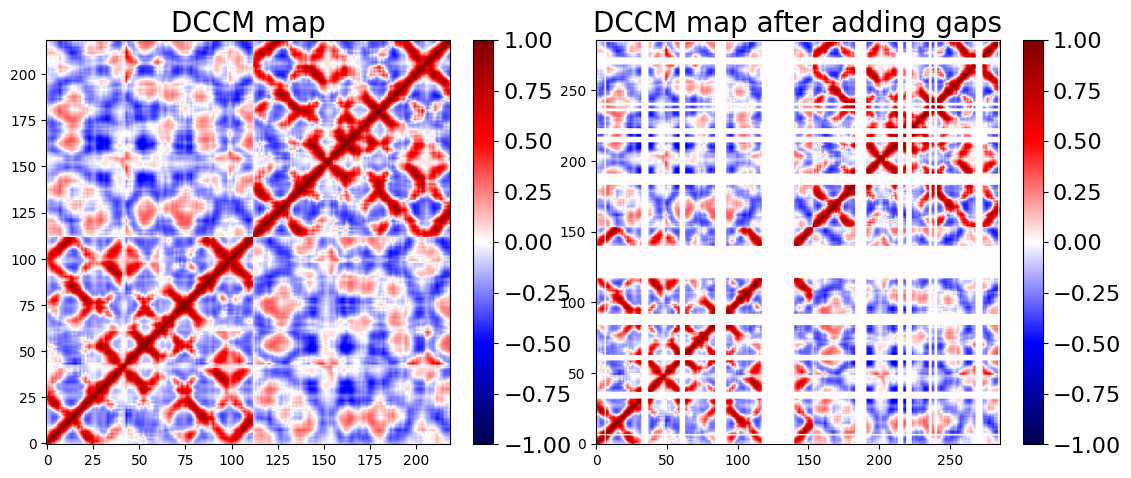

In [ ]:
title_size = 20

input_shape = train_x.shape[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.25))
im1 = ax1.imshow(raw_imgs[6], origin='lower', cmap='seismic', norm=CenteredNorm())
im2 = ax2.imshow(train_x[6].reshape(input_shape, input_shape), origin='lower', cmap='seismic', norm=CenteredNorm())

ax1.set_title('DCCM map', size=title_size)
ax2.set_title('DCCM map after adding gaps', size=title_size)

cb1 = plt.colorbar(im1, ax=ax1, fraction=0.045)
cb2 = plt.colorbar(im2, ax=ax2, fraction=0.045)

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)
cb1.ax.tick_params(labelsize=16)
cb2.ax.tick_params(labelsize=16)

plt.show()

# Training

## Import

In [23]:
!pip install adabelief_pytorch

In [24]:
import numpy as np
import torch
from torch.nn import MSELoss
from torch.optim import Adam

from adabelief_pytorch import AdaBelief
from sklearn.model_selection import train_test_split

## Split data

In [25]:
def create_test_set(train_x, train_y, test_size=None, random_state=0):
    r"""Creates the test set given a set of input images and their corresponding labels.

    Parameters
    ----------
    train_x: numpy.ndarray
        Input normal mode correlation maps.
    train_y: numpy.ndarray
        Labels.
    test_size: float
        Fraction of original samples to be included in the test set.
    random_state: int
        Set lot number.

    Returns
    -------
    train_x: torch.Tensor
        Training inputs.
    test_x: torch.Tensor
        Test inputs.
    train_y: torch.Tensor
        Training labels.
    test_y: torch.Tensor
        Test labels.

    """

    # Splitting
    indices = np.arange(len(train_x))
    train_x, test_x, train_y, test_y, indices_train, indices_test = train_test_split(train_x, train_y, indices, test_size=0.023, random_state=23)

    # Converting to tensors
    train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[1])
    train_x = train_x.astype(np.float32)
    train_x  = torch.from_numpy(train_x)
    train_y = train_y.astype(np.float32).reshape(train_y.shape[0], 1)
    train_y = torch.from_numpy(train_y)

    test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[2], test_x.shape[2])
    test_x = test_x.astype(np.float32)
    test_x  = torch.from_numpy(test_x)
    test_y = test_y.astype(np.float32).reshape(test_y.shape[0], 1, 1)
    test_y = torch.from_numpy(test_y)

    return train_x, test_x, train_y, test_y, indices_train, indices_test

In [26]:
train_x, test_x, train_y, test_y, idx_tr, idx_te = create_test_set(train_x, train_y, test_size=0.1)

In [27]:
train_x.shape

torch.Size([619, 1, 286, 286])

## Model CNN

In [ ]:
import numpy as np
import torch
from torch.nn import Linear, ReLU, Conv2d, MaxPool2d, Module

def create_model(n_filters=2, filter_size=4, pooling_size=1, input_shape=281, l1_lambda=0.002, mode='full'):
    model = {
        'n_filters': n_filters,
        'filter_size': filter_size,
        'pooling_size': pooling_size,
        'input_shape': input_shape,
        'l1_lambda': l1_lambda,
        'mode': mode
    }
    if mode == 'full':
        model['fully_connected_input'] = n_filters * ((input_shape - filter_size + 1) // pooling_size) ** 2
        model['conv1'] = Conv2d(1, n_filters, filter_size)
        model['pool'] = MaxPool2d(pooling_size, pooling_size)
        model['relu'] = ReLU()
    else:
        model['fully_connected_input'] = input_shape ** 2
    model['fc1'] = Linear(model['fully_connected_input'], 1, bias=False)
    return model

def forward_pass(model, x):
    if model['mode'] == 'full':
        x = model['conv1'](x) + torch.transpose(model['conv1'](x), 2, 3)
        x = model['relu'](x)
        inter = x = model['pool'](x)
    else:
        inter = x
    x = x.view(x.size(0), -1)
    x = model['fc1'](x)
    return x.float(), inter

def l1_regularization_loss(model):
    l1_loss = torch.tensor(0.0)
    for key in model:
        if 'conv1' in key or 'fc1' in key:
            l1_loss += torch.norm(model[key].weight, p=1)
    return model['l1_lambda'] * l1_loss

In [ ]:
import numpy as np
import torch
from torch.nn import Linear, ReLU, Conv2d, MaxPool2d, Module

class ANTIPASTI(Module):
    r"""Predicting the binding affinity of an antibody from its normal mode correlation map.

    Parameters
    ----------
    n_filters: int
        Number of filters in the convolutional layer.
    filter_size: int
        Size of filters in the convolutional layer.
    pooling_size: int
        Size of the max pooling operation.
    input_shape: int
        Shape of the normal mode correlation maps.
    l1_lambda: float
        Weight of L1 regularisation.
    mode: str
        To use the full model, provide ``full``. Otherwise, ANTIPASTI corresponds to a linear map.

    """
    def __init__(
            self,
            n_filters=2,
            filter_size=4,
            pooling_size=1,
            input_shape=281,
            l1_lambda=0.002,
            mode='full',
    ):
        super(ANTIPASTI, self).__init__()
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.pooling_size = pooling_size
        self.input_shape = input_shape
        self.mode = mode
        if self.mode == 'full':
            self.fully_connected_input = n_filters * ((input_shape-filter_size+1)//pooling_size) ** 2
            self.conv1 = Conv2d(1, n_filters, filter_size)
            self.pool = MaxPool2d((pooling_size, pooling_size))
            self.relu = ReLU()
        else:
            self.fully_connected_input = self.input_shape ** 2
        self.fc1 = Linear(self.fully_connected_input, 1, bias=False)
        self.l1_lambda = l1_lambda

    def forward(self, x):
        r"""Model's forward pass.

        Returns
        -------
        output: torch.Tensor
            Predicted binding affinity.
        inter_filter: torch.Tensor
            Filters before the fully-connected layer.

        """
        inter = x
        if self.mode == 'full':
            x = self.conv1(x) + torch.transpose(self.conv1(x), 2, 3)
            x = self.relu(x)
            inter = x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x.float(), inter

    def l1_regularization_loss(self):
        l1_loss = torch.tensor(0.0)
        for param in self.parameters():
            l1_loss += torch.norm(param, p=1)
        return self.l1_lambda * l1_loss

In [ ]:
n_filters = 4
filter_size = 4
pooling_size = 2
learning_rate = 1e-4
input_shape = train_x.shape[-1]

# Defining the model, optimiser and loss function
model = ANTIPASTI(n_filters=n_filters, filter_size=filter_size, pooling_size=pooling_size, input_shape=input_shape, l1_lambda=0.002)
criterion = MSELoss()
optimiser = AdaBelief(model.parameters(), lr=learning_rate, weight_decay=False, eps=1e-8, print_change_log=False)
# optimiser = Adam(model.parameters(), lr=learning_rate)
print(model)

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
ANTIPASTI(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=79524, out_features=1, bias=False)
)


### Training

In [ ]:
from torch.autograd import Variable

In [ ]:
def training_step(model, criterion, optimiser, train_x, test_x, train_y, test_y, train_losses, test_losses, epoch, batch_size, verbose):
    r"""Performs a training step.

    Parameters
    ----------
    model: antipasti.model.model.ANTIPASTI
        The model class, i.e., ``ANTIPASTI``.
    criterion: torch.nn.modules.loss.MSELoss
        It calculates a gradient according to a selected loss function, i.e., ``MSELoss``.
    optimiser: adabelief_pytorch.AdaBelief.AdaBelief
        Method that implements an optimisation algorithm.
    train_x: torch.Tensor
        Training normal mode correlation maps.
    test_x: torch.Tensor
        Test normal mode correlation maps.
    train_y: torch.Tensor
        Training labels.
    test_y: torch.Tensor
        Test labels.
    train_losses: list
        The current history of training losses.
    test_losses: list
        The current history of test losses.
    epoch: int
        Of value ``e`` if the dataset has gone through the model ``e`` times.
    batch_size: int
        Number of samples that pass through the model before its parameters are updated.
    verbose: bool
        ``True`` to print the losses in each epoch.

    Returns
    -------
    train_losses: list
        The history of training losses after the training step.
    test_losses: list
        The history of test losses after the training step.
    inter_filter: torch.Tensor
        Filters before the fully-connected layer.
    y_test: torch.Tensor
        Ground truth test labels.
    output_test: torch.Tensor
        The predicted test labels.

    """
    tr_loss = 0
    tr_mse = 0
    x_train, y_train = Variable(train_x), Variable(train_y)
    x_test, y_test = Variable(test_x), Variable(test_y)

    # Filters before the fully-connected layer
    size_inter = int(np.sqrt(model.fully_connected_input/model.n_filters))
    inter_filter = np.zeros((x_train.size()[0], model.n_filters, size_inter, size_inter))
    if model.mode != 'full':
        inter_filter = np.zeros((x_train.size()[0], 1, model.input_shape, model.input_shape))
    permutation = torch.randperm(x_train.size()[0])

    for i in range(0, x_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]

        # Training output
        output_train, inter_filters = model(batch_x)

        # Picking the appropriate filters before the fully-connected layer
        inter_filters_detached = inter_filters.detach().clone()
        inter_filter[i:i+batch_size] = inter_filters_detached.numpy()

        # Training loss, clearing gradients and updating weights
        optimiser.zero_grad()
        l1_loss = model.l1_regularization_loss()
        mse_loss = criterion(output_train[:, 0], batch_y[:, 0])
        loss_train = mse_loss + l1_loss
        if verbose:
            print(l1_loss)
        loss_train.backward()
        optimiser.step()
        # Adding batch contribution to training loss
        tr_loss += loss_train.item() * batch_size / x_train.size()[0]
        tr_mse += mse_loss * batch_size / x_train.size()[0]

    train_losses.append(tr_loss)
    loss_test = 0
    output_test = []

    with torch.no_grad():
        for i in range(x_test.size()[0]):
            optimiser.zero_grad()
            output_t, _ = model(x_test[i].reshape(1, 1, model.input_shape, model.input_shape))
            l1_loss = model.l1_regularization_loss()
            loss_t = criterion(output_t[:, 0], y_test[i][:, 0])
            loss_test += loss_t.item() / x_test.size()[0]
            if verbose:
                print(output_t)
                print(y_test[i])
                print('------------------------')
            output_test.append(output_t[:,0].detach().numpy())
    test_losses.append(loss_test)

    # Training and test losses
    if verbose:
        print('Epoch : ', epoch+1, '\t', 'train loss: ', tr_loss, 'train MSE: ', tr_mse, 'test MSE: ', loss_test)


    return train_losses, test_losses, inter_filter, y_test, output_test

In [ ]:
def training_routine(model, criterion, optimiser, train_x, test_x, train_y, test_y, n_max_epochs=120, max_corr=0.87, batch_size=32, verbose=True):
    r"""Performs a chosen number of training steps.

    Parameters
    ----------
    model: antipasti.model.model.ANTIPASTI
        The model class, i.e., ``ANTIPASTI``.
    criterion: torch.nn.modules.loss.MSELoss
        It calculates a gradient according to a selected loss function, i.e., ``MSELoss``.
    optimiser: adabelief_pytorch.AdaBelief.AdaBelief
        Method that implements an optimisation algorithm.
    train_x: torch.Tensor
        Training normal mode correlation maps.
    test_x: torch.Tensor
        Test normal mode correlation maps.
    train_y: torch.Tensor
        Training labels.
    test_y: torch.Tensor
        Test labels.
    n_max_epochs: int
        Number of times the whole dataset goes through the model.
    max_corr: float
        If the correlation coefficient exceeds this value, the training routine is terminated.
    batch_size: int
        Number of samples that pass through the model before its parameters are updated.
    verbose: bool
        ``True`` to print the losses in each epoch.

    Returns
    -------
    train_losses: list
        The history of training losses after the training routine.
    test_losses: list
        The history of test losses after the training routine.
    inter_filter: torch.Tensor
        Filters before the fully-connected layer.
    y_test: torch.Tensor
        Ground truth test labels.
    output_test: torch.Tensor
        The predicted test labels.

    """
    train_losses = []
    test_losses = []

    for epoch in range(n_max_epochs):
        train_losses, test_losses, inter_filter, y_test, output_test = training_step(model, criterion, optimiser, train_x, test_x, train_y, test_y, train_losses, test_losses, epoch, batch_size, verbose)

        # Computing and printing the correlation coefficient
        corr = np.corrcoef(np.array(output_test).T, y_test[:,0].detach().numpy().T)[1,0]
        if verbose:
            print('Corr: ' + str(corr))
        if corr > max_corr:
            break

    return train_losses, test_losses, inter_filter, y_test, output_test

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

79592

In [ ]:
train_losses = []
test_losses = []

In [ ]:
model.train()
n_max_epochs = 50 # This is just a super short example. You can increase this.
max_corr = 0.87
batch_size = 32

train_loss, test_loss, inter_filter, y_test, output_test = training_routine(model, criterion, optimiser, train_x, test_x, train_y, test_y, n_max_epochs=n_max_epochs, max_corr=max_corr, batch_size=batch_size)

# Saving the losses
train_losses.extend(train_loss)
test_losses.extend(test_loss)

tensor(0.2905, grad_fn=<MulBackward0>)
tensor(0.2905, grad_fn=<MulBackward0>)
tensor(0.2904, grad_fn=<MulBackward0>)
tensor(0.2904, grad_fn=<MulBackward0>)
tensor(0.2904, grad_fn=<MulBackward0>)
tensor(0.2904, grad_fn=<MulBackward0>)
tensor(0.2903, grad_fn=<MulBackward0>)
tensor(0.2902, grad_fn=<MulBackward0>)
tensor(0.2901, grad_fn=<MulBackward0>)
tensor(0.2900, grad_fn=<MulBackward0>)
tensor(0.2900, grad_fn=<MulBackward0>)
tensor(0.2899, grad_fn=<MulBackward0>)
tensor(0.2898, grad_fn=<MulBackward0>)
tensor(0.2896, grad_fn=<MulBackward0>)
tensor(0.2895, grad_fn=<MulBackward0>)
tensor(0.2893, grad_fn=<MulBackward0>)
tensor(0.2892, grad_fn=<MulBackward0>)
tensor(0.2890, grad_fn=<MulBackward0>)
tensor(0.2889, grad_fn=<MulBackward0>)
tensor(0.2887, grad_fn=<MulBackward0>)
tensor([[-6.4571]])
tensor([[-6.4202]])
------------------------
tensor([[-7.6833]])
tensor([[-7.1427]])
------------------------
tensor([[-7.8261]])
tensor([[-8.0506]])
------------------------
tensor([[-8.0792]])
tenso

In [ ]:
   print("Unique y_test:", np.unique(y_test.detach().numpy()))
   print("Unique output_test:", np.unique(np.array(output_test)))

Unique y_test: [-8.102373]
Unique output_test: [-8.350439]


In [ ]:
   print("NaN in y_test:", np.isnan(y_test.detach().numpy()).any())
   print("NaN in output_test:", np.isnan(np.array(output_test)).any())
   print("Inf in y_test:", np.isinf(y_test.detach().numpy()).any())
   print("Inf in output_test:", np.isinf(np.array(output_test)).any())

NaN in y_test: False
NaN in output_test: False
Inf in y_test: False
Inf in output_test: False


In [ ]:
   for name, param in model.named_parameters():
       if param.requires_grad:
           print(name, param.grad)

conv1.weight None
conv1.bias None
fc1.weight None


### Ploting

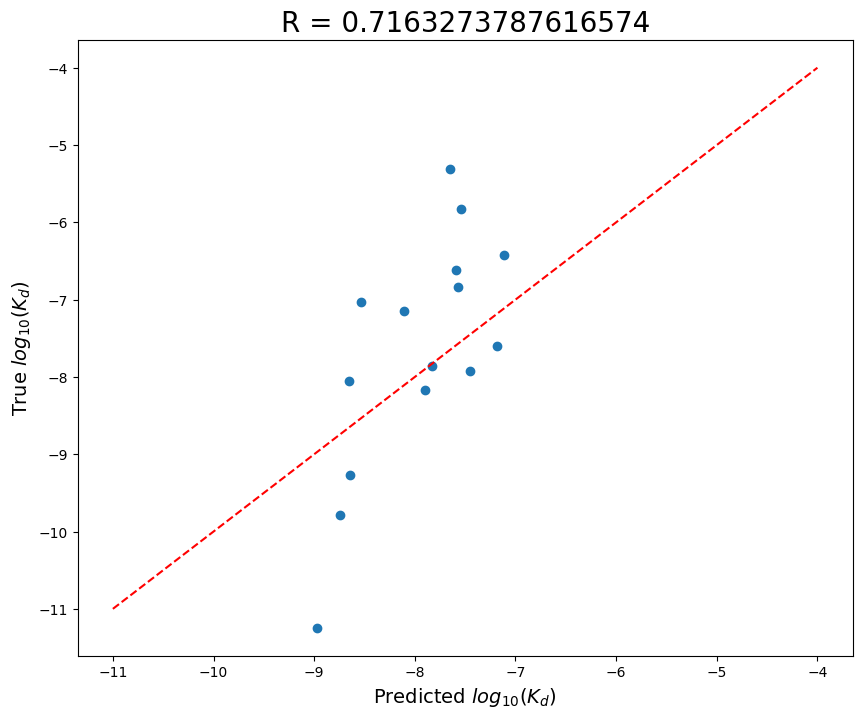

In [ ]:
font_size = 14

fig = plt.figure(figsize=(10, 8))
plt.scatter(np.array(output_test), y_test[:,0].detach().numpy())
corr = np.corrcoef(np.array(output_test).T, y_test[:,0].detach().numpy().T)[1,0]
plt.plot([-11,-4],[-11,-4], c='r', linestyle='dashed')
plt.title('R = '+str(corr), size=title_size)
plt.xlabel('Predicted $log_{10}$($K_d$)', size=font_size)
plt.ylabel('True $log_{10}$($K_d$)', size=font_size)
plt.show()

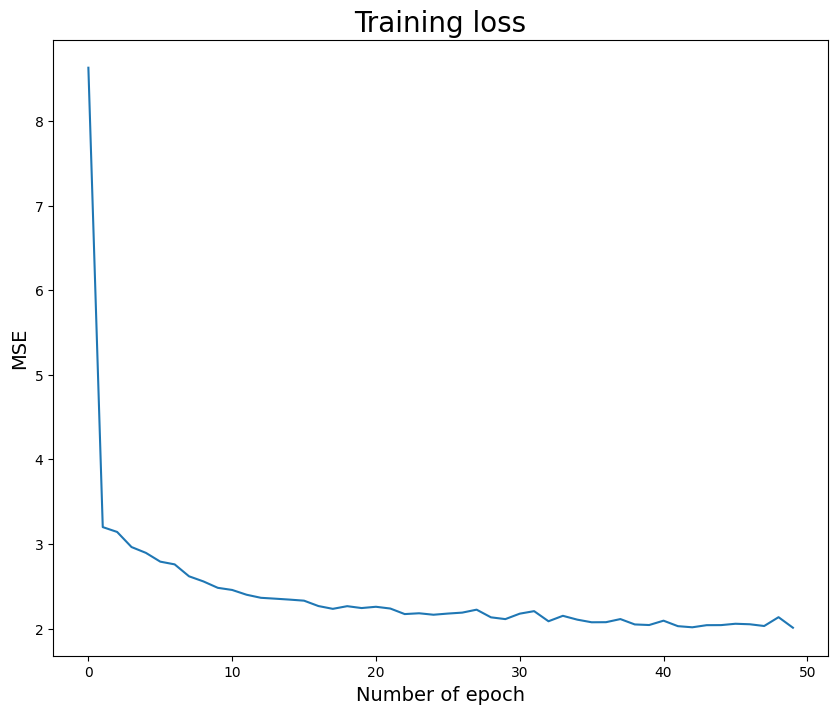

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

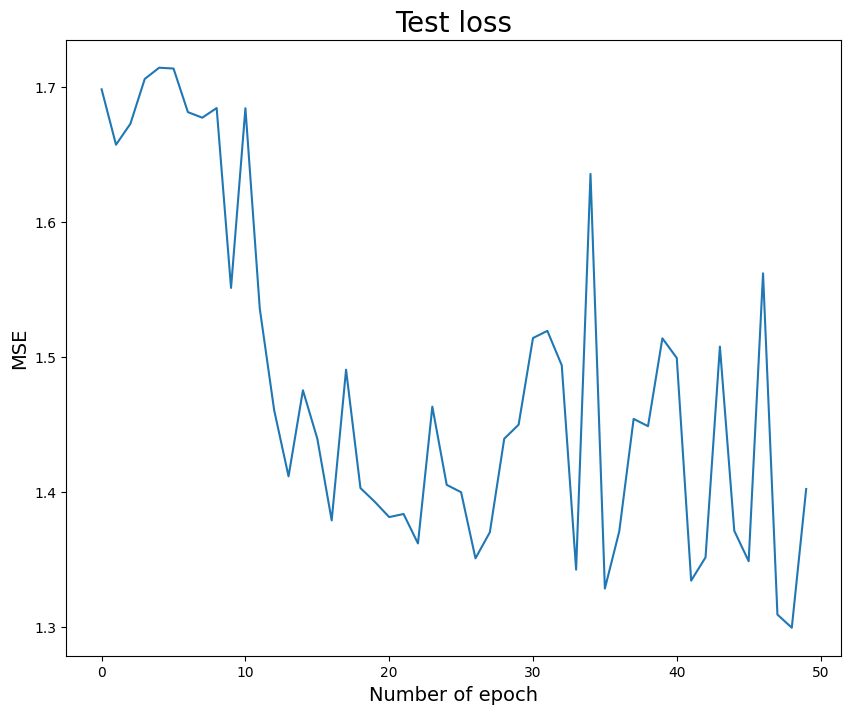

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.plot([test_losses[i] for i in range(len(test_losses))])
plt.title('Test loss', size=title_size)
plt.xlabel('Number of epoch', size=font_size)
plt.ylabel('MSE', size=font_size)
plt.show()

## Model Vim

In [28]:
!pip install vision-mamba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.1/531.1 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.6/241.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#### Training

In [29]:
from vision_mamba.model import Vim

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [36]:
import torch
import torch.optim as optim
from torch.nn import MSELoss
from torch.utils.data import DataLoader, TensorDataset
from vision_mamba.model import Vim
import numpy as np
import time

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming train_x and train_y are your input arrays
train_x_t = torch.tensor(train_x, dtype=torch.float32).to(device)
train_y_t = torch.tensor(train_y, dtype=torch.float32).to(device)
test_x_t = torch.tensor(test_x, dtype=torch.float32).to(device)
test_y_t = torch.tensor(test_y, dtype=torch.float32).to(device)

# Create TensorDataset and DataLoader for training and validation datasets
train_dataset = TensorDataset(train_x_t, train_y_t)
test_dataset = TensorDataset(test_x_t, test_y_t)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize the Vim model
model = Vim(
    dim=128,
    dt_rank=32,
    dim_inner=128,
    d_state=97,
    num_classes=1,  # For regression, typically the output is a single value per instance
    image_size=286,
    patch_size=13,
    channels=1,
    dropout=0.2677301595791723,
    depth=7,
)

# Move the model to the GPU
model.to(device)

# Using Mean Squared Error Loss for a regression task
criterion = MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00015334092031733988)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Print the model architecture
print(model)

Vim(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=13, p2=13)
    (1): Linear(in_features=169, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.2677301595791723, inplace=False)
  (to_latent): Identity()
  (layers): ModuleList(
    (0-6): 7 x VisionEncoderMambaBlock(
      (forward_conv1d): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (backward_conv1d): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (silu): SiLU()
      (ssm): SSM(
        (deltaBC_layer): Linear(in_features=128, out_features=226, bias=False)
        (dt_proj_layer): Linear(in_features=32, out_features=128, bias=True)
      )
      (proj): Linear(in_features=128, out_features=128, bias=True)
      (softplus): Softplus(beta=1.0, threshold=20.0)
    )
  )
  (output_head): Sequential(
    (0): Reduce('b s d -> b d', 'mean')
    (1): LayerNorm((128,), eps=1e-05, elementwise_affin

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

690689

In [ ]:
# Training loop
model.train()  # Set the model to training mode
num_epochs = 50  # Define the number of epochs
verbose = True  # Set verbose to True to print correlation

# Initialize lists to store the loss and correlation values for each epoch
loss_values = []
correlation_values = []

# Record the start time
start_time = time.time()

for epoch in range(num_epochs):
    total_loss = 0.0
    num_batches = 0
    outputs_all = []
    targets_all = []

    for batch_inputs, batch_targets in train_loader:
        # Move the inputs and targets to the GPU
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()
        num_batches += 1

        # Debugging shapes
        print("Output shape:", outputs.shape)
        print("Target shape:", batch_targets.shape)

        # Collect outputs and targets for correlation, ensure they are flattened
        outputs_all.append(outputs.view(-1).detach().cpu().numpy())
        targets_all.append(batch_targets.view(-1).detach().cpu().numpy())

    # Calculate average loss for the epoch
    average_loss = total_loss / num_batches
    print(f'Epoch {epoch + 1}: Average Loss {average_loss:.4f}')

    # Compute correlation
    outputs_flat = np.concatenate(outputs_all)
    targets_flat = np.concatenate(targets_all)
    corr = np.corrcoef(outputs_flat, targets_flat)[0, 1]
    if verbose:
        print('Epoch {}: Correlation: {:.4f}'.format(epoch + 1, corr))

    # Append loss and correlation values to the lists
    loss_values.append(average_loss)
    correlation_values.append(corr)

# Record the end time
end_time = time.time()

# Calculate and print the total training time
total_training_time = end_time - start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')

Streaming output truncated to the last 5000 lines.
         [18.2316,  1.6594,  0.1022,  ...,  4.3237, 20.1772, 16.8943],
         ...,
         [ 8.8683,  0.0333,  1.3466,  ...,  0.1131,  8.5402,  7.2470],
         [16.6994,  2.1070,  0.2097,  ...,  4.9018, 19.3762, 16.7119],
         [26.2654,  2.1463,  0.1198,  ...,  5.9613, 28.2358, 23.7907]]],
       device='cuda:0', grad_fn=<SoftplusBackward0>)
Layer: torch.Size([1, 484, 128])
Conv1d: tensor([[[0.5158, 0.4844, 0.5192,  ..., 0.4431, 0.4376, 0.5152],
         [0.6210, 1.0545, 1.0758,  ..., 1.1472, 0.9551, 0.9008],
         [0.5311, 0.4432, 0.8152,  ..., 0.4770, 0.7012, 0.6640],
         ...,
         [0.7327, 0.5902, 0.4661,  ..., 0.4687, 0.3462, 0.4742],
         [0.5844, 0.4791, 0.9321,  ..., 0.4961, 0.7701, 0.7035],
         [0.6191, 0.4252, 0.6078,  ..., 0.4455, 0.6459, 0.6989]]],
       device='cuda:0', grad_fn=<SoftplusBackward0>)
Conv1d: tensor([[[0.5566, 0.4938, 0.7569,  ..., 0.5092, 0.7383, 0.7145],
         [0.5686, 0.556

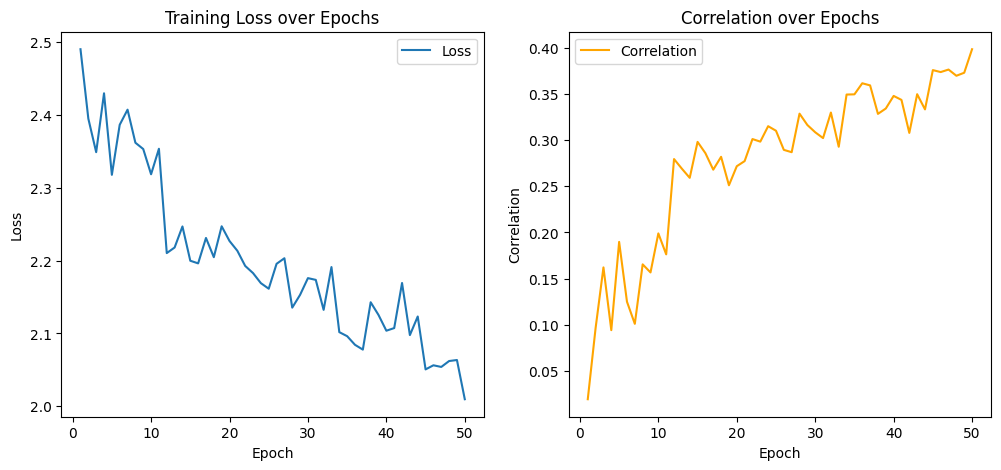

In [ ]:
# Plotting loss and correlation
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_values, label='Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot correlation
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), correlation_values, label='Correlation', color='orange')
plt.title('Correlation over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.legend()

plt.show()

# # Save the plot to a file
# plt.savefig('training_performance.png')
# plt.close()  # Close the figure to free up memory

In [ ]:
def calculate_correlation(outputs, targets):
    # outputs = outputs.detach().cpu().numpy()
    # targets = targets.detach().cpu().numpy()
    if np.std(outputs) == 0 or np.std(targets) == 0:
        return 0  # Avoid division by zero
    return np.corrcoef(outputs, targets)[0, 1]

In [ ]:
# Training loop
model.train()
num_epochs = 15
verbose = True

# Initialize lists to store the loss and correlation values for each epoch
train_loss_values = []
train_correlation_values = []
val_loss_values = []
val_correlation_values = []

# Record the start time
start_time = time.time()

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0.0
    num_train_batches = 0
    train_outputs_all = []
    train_targets_all = []

    for batch_inputs, batch_targets in train_loader:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_train_loss += loss.item()
        num_train_batches += 1

        # Collect outputs and targets for correlation
        train_outputs_all.append(outputs.view(-1).detach().cpu().numpy())
        train_targets_all.append(batch_targets.view(-1).detach().cpu().numpy())

    # Step the scheduler
    scheduler.step()

    # Calculate average training loss for the epoch
    average_train_loss = total_train_loss / num_train_batches
    print(f'Epoch {epoch + 1}: Average Training Loss {average_train_loss:.4f}')

    # Compute training correlation
    train_outputs_flat = np.concatenate(train_outputs_all)
    train_targets_flat = np.concatenate(train_targets_all)
    train_corr = calculate_correlation(train_outputs_flat, train_targets_flat)
    if verbose:
        print(f'Epoch {epoch + 1}: Training Correlation: {train_corr:.4f}')

    # Append training loss and correlation values to the lists
    train_loss_values.append(average_train_loss)
    train_correlation_values.append(train_corr)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    num_val_batches = 0
    val_outputs_all = []
    val_targets_all = []

    with torch.no_grad():
        for val_inputs, val_targets in test_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

            # Forward pass
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)

            # Accumulate loss
            total_val_loss += val_loss.item()
            num_val_batches += 1

            # Collect outputs and targets for correlation
            val_outputs_all.append(val_outputs.view(-1).cpu().numpy())
            val_targets_all.append(val_targets.view(-1).cpu().numpy())

    # Calculate average validation loss for the epoch
    average_val_loss = total_val_loss / num_val_batches
    print(f'Epoch {epoch + 1}: Average Validation Loss {average_val_loss:.4f}')

    # Compute validation correlation
    val_outputs_flat = np.concatenate(val_outputs_all)
    val_targets_flat = np.concatenate(val_targets_all)
    val_corr = calculate_correlation(val_outputs_flat, val_targets_flat)
    if verbose:
        print(f'Epoch {epoch + 1}: Validation Correlation: {val_corr:.4f}')

    # Append validation loss and correlation values to the lists
    val_loss_values.append(average_val_loss)
    val_correlation_values.append(val_corr)

# Record the end time
end_time = time.time()

# Calculate and print the total training time
total_training_time = end_time - start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')

Streaming output truncated to the last 5000 lines.
         [0.7553, 0.3556, 1.3139,  ..., 0.4560, 0.8735, 0.8411],
         [1.4965, 0.6597, 1.4513,  ..., 0.7429, 1.3487, 1.3553],
         [1.1882, 0.7464, 1.0300,  ..., 0.6779, 0.9088, 1.0957]]],
       device='cuda:0', grad_fn=<SoftplusBackward0>)
Conv1d: tensor([[[0.9557, 0.9972, 1.5714,  ..., 0.7137, 1.5067, 1.1116],
         [0.7554, 0.6382, 0.7253,  ..., 0.6024, 0.5236, 0.7222],
         [0.7007, 0.5524, 0.6171,  ..., 0.9171, 0.7180, 0.7360],
         ...,
         [0.6354, 0.6880, 1.4142,  ..., 0.4260, 1.5837, 0.6061],
         [0.8710, 1.3521, 0.4377,  ..., 1.0838, 0.4529, 0.7895],
         [1.3023, 0.9740, 0.8419,  ..., 0.9794, 1.0162, 1.3079]]],
       device='cuda:0', grad_fn=<SoftplusBackward0>)
Layer: torch.Size([1, 484, 128])
Conv1d: tensor([[[0.6078, 0.6436, 0.9470,  ..., 0.7135, 0.6545, 0.7038],
         [0.6106, 0.8595, 0.5997,  ..., 0.8925, 0.6242, 0.6456],
         [0.4740, 0.6613, 0.6067,  ..., 0.6901, 0.5799, 0.530

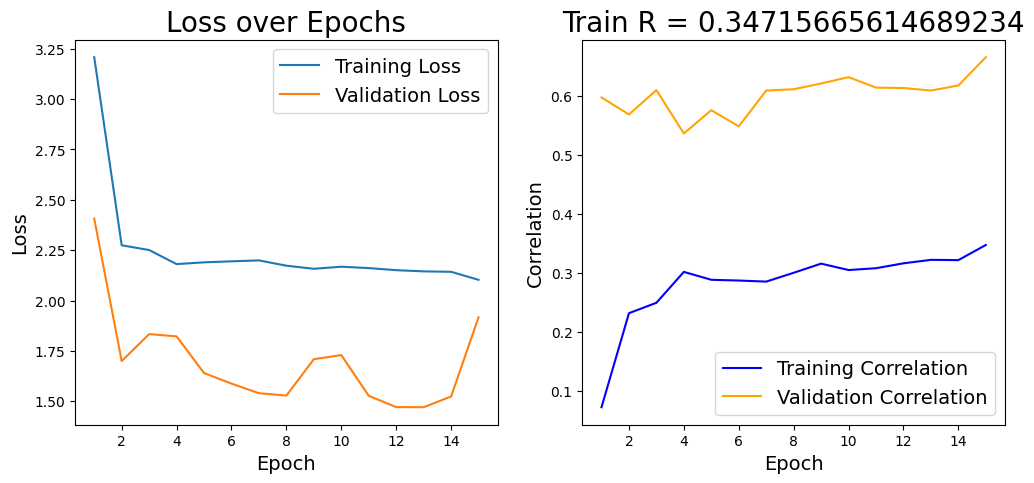

In [ ]:
# Plotting loss and correlation
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_values, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_values, label='Validation Loss')
plt.title('Loss over Epochs', size=20)
plt.xlabel('Epoch', size=14)
plt.ylabel('Loss', size=14)
plt.legend(prop={'size': 14})

# Plot training and validation correlation
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_correlation_values, label='Training Correlation', color='blue')
plt.plot(range(1, num_epochs + 1), val_correlation_values, label='Validation Correlation', color='orange')
plt.title('Train R = '+str(train_correlation_values[-1]), size=20)
plt.xlabel('Epoch', size=14)
plt.ylabel('Correlation', size=14)
plt.legend(prop={'size': 14})

plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib
import sklearn

print(f'PyTorch version: {torch.__version__}')
print(f'numpy version: {np.__version__}')
print(f'matplotlib version: {matplotlib.__version__}')
print(f'sklearn version: {sklearn.__version__}')


PyTorch version: 2.3.1+cu121
numpy version: 1.25.2
matplotlib version: 3.7.1
sklearn version: 1.2.2


# Predicting

In [ ]:
# Load the model state dictionary
model_load_path = '/content/cnn_model.pth'
model.load_state_dict(torch.load(model_load_path))
# model.to(device)  # Ensure the model is on the correct device

model.eval()

ANTIPASTI(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=79524, out_features=1, bias=False)
)

In [ ]:
test_x[1].shape

torch.Size([1, 286, 286])

In [ ]:
test = test_x[10].reshape(1, 1, test_x.shape[-1], test_x.shape[-1])
test.shape

torch.Size([1, 1, 286, 286])

In [ ]:
print('The output value is ' + str(model(test)[0].detach().numpy()[0,0]))
print('So the predicted binding affinity is ' + str(10**model(test)[0].detach().numpy()[0,0]))

The output value is -7.1137123
So the predicted binding affinity is 7.696401032949482e-08


In [ ]:
test_y[10]

tensor([[-5.3098]])

vim

In [ ]:
# Load the model state dictionary
model_load_path = '/content/vim_model.pth'
model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))

model.eval()

Vim(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=13, p2=13)
    (1): Linear(in_features=169, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.2677301595791723, inplace=False)
  (to_latent): Identity()
  (layers): ModuleList(
    (0-6): 7 x VisionEncoderMambaBlock(
      (forward_conv1d): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (backward_conv1d): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (silu): SiLU()
      (ssm): SSM(
        (deltaBC_layer): Linear(in_features=128, out_features=226, bias=False)
        (dt_proj_layer): Linear(in_features=32, out_features=128, bias=True)
      )
      (proj): Linear(in_features=128, out_features=128, bias=True)
      (softplus): Softplus(beta=1.0, threshold=20.0)
    )
  )
  (output_head): Sequential(
    (0): Reduce('b s d -> b d', 'mean')
    (1): LayerNorm((128,), eps=1e-05, elementwise_affin

In [ ]:
print('The output value is ' + str(model(test)[0].detach().numpy()[0]))
print('So the predicted binding affinity is ' + str(10**model(test)[0].detach().numpy()[0]))

Patch embedding: torch.Size([1, 484, 128])
Cls tokens: torch.Size([1, 1, 128])
torch.Size([1, 484, 128])
Conv1d: tensor([[[0.9474, 0.6807, 0.2928,  ..., 0.6029, 0.6420, 1.2937],
         [0.7916, 0.4245, 0.4723,  ..., 0.5548, 0.4489, 0.9730],
         [0.1153, 0.3094, 1.7163,  ..., 0.2363, 0.4514, 0.0484],
         ...,
         [0.4750, 0.5934, 0.4259,  ..., 0.5131, 0.4892, 0.4919],
         [0.5604, 0.2781, 0.6260,  ..., 0.2975, 0.6887, 0.6320],
         [1.0489, 0.9131, 0.2524,  ..., 1.0984, 0.4901, 1.0252]]],
       grad_fn=<SoftplusBackward0>)
Conv1d: tensor([[[1.3666, 0.7755, 0.8540,  ..., 0.5437, 1.3403, 1.5644],
         [0.4224, 0.6733, 1.8863,  ..., 0.4453, 0.9782, 0.3074],
         [0.3935, 0.7531, 1.2295,  ..., 0.3327, 1.3550, 0.4290],
         ...,
         [0.1077, 0.3345, 0.2452,  ..., 0.4059, 0.2080, 0.1053],
         [0.3135, 0.6344, 1.8774,  ..., 0.1805, 0.8599, 0.3511],
         [0.6303, 0.4604, 0.1978,  ..., 1.1164, 0.4003, 0.7945]]],
       grad_fn=<SoftplusBackwar

## all data

### Vim

In [38]:
# Load the model state dictionary
model_load_path = '/content/vim_model.pth'
model.load_state_dict(torch.load(model_load_path, map_location=torch.device('cpu')))

model.eval()

Vim(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=13, p2=13)
    (1): Linear(in_features=169, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.2677301595791723, inplace=False)
  (to_latent): Identity()
  (layers): ModuleList(
    (0-6): 7 x VisionEncoderMambaBlock(
      (forward_conv1d): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (backward_conv1d): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (silu): SiLU()
      (ssm): SSM(
        (deltaBC_layer): Linear(in_features=128, out_features=226, bias=False)
        (dt_proj_layer): Linear(in_features=32, out_features=128, bias=True)
      )
      (proj): Linear(in_features=128, out_features=128, bias=True)
      (softplus): Softplus(beta=1.0, threshold=20.0)
    )
  )
  (output_head): Sequential(
    (0): Reduce('b s d -> b d', 'mean')
    (1): LayerNorm((128,), eps=1e-05, elementwise_affin

In [39]:
# Initialize an empty DataFrame with the required columns
results_df = pd.DataFrame(columns=['Predicted Output', 'Predicted Affinity', 'True Output'])

# Loop through the test data
for i in range(len(test_x)):
    # Reshape the test data
    test = test_x[i].reshape(1, 1, test_x.shape[-1], test_x.shape[-1])

    # Make the prediction
    predicted_output = str(model(test)[0].detach().numpy()[0])

    # Calculate the predicted affinity
    predicted_affinity = str(10**model(test)[0].detach().numpy()[0])

    # Get the true output
    true_output = test_y[i].detach().numpy()[0, 0]

    # Append the results to the DataFrame using loc
    results_df.loc[i] = [predicted_output, predicted_affinity, true_output]


Patch embedding: torch.Size([1, 484, 128])
Cls tokens: torch.Size([1, 1, 128])
torch.Size([1, 484, 128])
Conv1d: tensor([[[0.9249, 0.7178, 0.2869,  ..., 0.5196, 0.4993, 1.3011],
         [0.7760, 0.4376, 0.4313,  ..., 0.5649, 0.4164, 0.9979],
         [0.1202, 0.2375, 1.7755,  ..., 0.2755, 0.7107, 0.0458],
         ...,
         [0.4820, 0.5919, 0.4192,  ..., 0.4678, 0.5215, 0.4858],
         [0.5272, 0.3191, 0.6289,  ..., 0.3053, 0.6699, 0.6618],
         [1.1139, 0.9709, 0.2786,  ..., 0.9981, 0.3965, 1.0225]]],
       grad_fn=<SoftplusBackward0>)
Conv1d: tensor([[[1.3508, 0.8164, 0.8372,  ..., 0.5399, 1.1844, 1.5707],
         [0.4577, 0.5532, 1.9323,  ..., 0.4755, 1.0590, 0.3012],
         [0.3969, 0.7512, 1.1966,  ..., 0.3126, 1.4273, 0.4065],
         ...,
         [0.1197, 0.2709, 0.3009,  ..., 0.3948, 0.1987, 0.1015],
         [0.3392, 0.5970, 1.7404,  ..., 0.1790, 1.0184, 0.3512],
         [0.6383, 0.5206, 0.2031,  ..., 1.1245, 0.4257, 0.7951]]],
       grad_fn=<SoftplusBackwar

In [40]:
results_df

,Predicted Output,Predicted Affinity,True Output
0,-6.3564553,4.4009321591704205e-07,-6.420217
1,-7.434359,3.678247312783554e-08,-7.142667
2,-8.742572,1.8089566905615997e-09,-8.050610
3,-8.099307,7.955966389636495e-09,-7.036212
4,-8.241764,5.73107288179903e-09,-9.273273
5,-8.108464,7.78996953023637e-09,-8.164310
6,-8.161515,6.894214064936733e-09,-7.920819
7,-8.109573,7.770100493830212e-09,-6.838632
8,-10.748591,1.784056388516652e-11,-11.244125
9,-7.54509,2.850426201688455e-08,-7.853872


### CNN

In [ ]:
# Load the model state dictionary
model_load_path = '/content/cnn_model.pth'
model.load_state_dict(torch.load(model_load_path))
# model.to(device)  # Ensure the model is on the correct device

model.eval()

ANTIPASTI(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=79524, out_features=1, bias=False)
)

In [ ]:
# Initialize an empty DataFrame with the required columns
results_df_cnn = pd.DataFrame(columns=['Predicted Output', 'Predicted Affinity', 'True Output'])

# Loop through the test data
for i in range(len(test_x)):
    # Reshape the test data
    test = test_x[i].reshape(1, 1, test_x.shape[-1], test_x.shape[-1])

    # Make the prediction
    predicted_output = str(model(test)[0].detach().numpy()[0])

    # Calculate the predicted affinity
    predicted_affinity = str(10**model(test)[0].detach().numpy()[0])

    # Get the true output
    true_output = test_y[i].detach().numpy()[0, 0]

    # Append the results to the DataFrame using loc
    results_df_cnn.loc[i] = [predicted_output, predicted_affinity, true_output]

In [ ]:
results_df_cnn

,Predicted Output,Predicted Affinity,True Output
0,[-5.5708294],[2.6863995e-06],-6.420217
1,[-7.2729807],[5.333586e-08],-7.142667
2,[-7.071369],[8.4845894e-08],-8.050610
3,[-7.241649],[5.7325895e-08],-7.036212
4,[-8.73309],[1.8488837e-09],-9.273273
5,[-8.359169],[4.373519e-09],-8.164310
6,[-7.4123955],[3.8690516e-08],-7.920819
7,[-7.5286365],[2.9604896e-08],-6.838632
8,[-9.545801],[2.8457636e-10],-11.244125
9,[-7.2715507],[5.3511773e-08],-7.853872


# Manual Calculation

In [20]:
train_x.shape

(634, 286, 286)

In [21]:
data1 = pd.DataFrame(train_x[1])
data1

,0,1,2,3,4,5,6,7,8,9,...,276,277,278,279,280,281,282,283,284,285
0,1.000000,0.589677,0.263204,0.164304,0.125258,0.034541,0.0,-0.006669,-0.010071,-0.020691,...,0.049064,0.072291,0.037360,0.018807,0.006218,-0.049198,-0.042646,-0.073390,0.0,-0.055045
1,0.589677,1.000000,0.752121,0.624775,0.509841,0.282767,0.0,0.144005,0.079211,0.011704,...,0.084365,0.135618,0.080356,0.046708,0.033893,-0.074711,-0.062403,-0.121481,0.0,-0.089284
2,0.263204,0.752121,1.000000,0.888385,0.791242,0.545288,0.0,0.360709,0.206093,0.078782,...,0.110281,0.150414,0.072871,0.011642,-0.014622,-0.148891,-0.132528,-0.195451,0.0,-0.147788
3,0.164304,0.624775,0.888385,1.000000,0.934094,0.798197,0.0,0.609805,0.350789,0.134009,...,0.097461,0.152357,0.063727,0.016733,-0.014970,-0.148340,-0.131519,-0.201839,0.0,-0.140069
4,0.125258,0.509841,0.791242,0.934094,1.000000,0.914035,0.0,0.779096,0.499270,0.250360,...,0.088579,0.114834,0.011614,-0.036281,-0.096428,-0.212885,-0.205008,-0.261098,0.0,-0.190367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,-0.049198,-0.074711,-0.148891,-0.148340,-0.212885,-0.241951,0.0,-0.271941,-0.324930,-0.390779,...,0.145853,0.343347,0.477934,0.717511,0.897363,1.000000,0.904560,0.743150,0.0,0.625763
282,-0.042646,-0.062403,-0.132528,-0.131519,-0.205008,-0.237649,0.0,-0.276435,-0.343613,-0.401946,...,-0.007158,0.176879,0.275974,0.512573,0.759512,0.904560,1.000000,0.920834,0.0,0.859296
283,-0.073390,-0.121481,-0.195451,-0.201839,-0.261098,-0.269857,0.0,-0.286309,-0.350349,-0.389145,...,-0.187716,-0.039993,0.027922,0.241307,0.507585,0.743150,0.920834,1.000000,0.0,0.957513
284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [ ]:
x = (286*286)/(13*13)
x

484.0

In [ ]:
subset = train_x[1][:16, :16]
datasubset = pd.DataFrame(subset)
datasubset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.589677,0.263204,0.164304,0.125258,0.034541,0.0,-0.006669,-0.010071,-0.020691,-0.031109,-0.032654,-0.053621,-0.050555,-0.049588,-0.056793
1,0.589677,1.000000,0.752121,0.624775,0.509841,0.282767,0.0,0.144005,0.079211,0.011704,-0.062005,-0.073724,-0.128376,-0.121539,-0.142718,-0.153274
2,0.263204,0.752121,1.000000,0.888385,0.791242,0.545288,0.0,0.360709,0.206093,0.078782,-0.060388,-0.101990,-0.196098,-0.196298,-0.227102,-0.239358
3,0.164304,0.624775,0.888385,1.000000,0.934094,0.798197,0.0,0.609805,0.350789,0.134009,-0.026023,-0.147499,-0.276534,-0.319562,-0.361963,-0.376145
4,0.125258,0.509841,0.791242,0.934094,1.000000,0.914035,0.0,0.779096,0.499270,0.250360,0.043235,-0.076488,-0.220256,-0.276926,-0.319402,-0.340451
5,0.034541,0.282767,0.545288,0.798197,0.914035,1.000000,0.0,0.910325,0.616759,0.353543,0.128749,-0.013188,-0.169731,-0.274022,-0.327111,-0.345932
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,-0.006669,0.144005,0.360709,0.609805,0.779096,0.910325,0.0,1.000000,0.750437,0.489914,0.288154,0.210145,0.008493,-0.134194,-0.199342,-0.233233
8,-0.010071,0.079211,0.206093,0.350789,0.499270,0.616759,0.0,0.750437,1.000000,0.776460,0.430497,0.444873,0.260587,0.095107,-0.006353,-0.118874
9,-0.020691,0.011704,0.078782,0.134009,0.250360,0.353543,0.0,0.489914,0.776460,1.000000,0.781234,0.688203,0.516669,0.278840,0.170926,0.037549


In [ ]:
x = (16*16)/(8*8)
x

4.0

In [ ]:
subset1 = subset[:8, 8:]
datasubset1 = pd.DataFrame(subset1)
datasubset1

,0,1,2,3,4,5,6,7
0,-0.010071,-0.020691,-0.031109,-0.032654,-0.053621,-0.050555,-0.049588,-0.056793
1,0.079211,0.011704,-0.062005,-0.073724,-0.128376,-0.121539,-0.142718,-0.153274
2,0.206093,0.078782,-0.060388,-0.101990,-0.196098,-0.196298,-0.227102,-0.239358
3,0.350789,0.134009,-0.026023,-0.147499,-0.276534,-0.319562,-0.361963,-0.376145
4,0.499270,0.250360,0.043235,-0.076488,-0.220256,-0.276926,-0.319402,-0.340451
5,0.616759,0.353543,0.128749,-0.013188,-0.169731,-0.274022,-0.327111,-0.345932
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.750437,0.489914,0.288154,0.210145,0.008493,-0.134194,-0.199342,-0.233233


## get calculation from vim

In [ ]:
!pip install vision-mamba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.1/531.1 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.6/241.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from vision_mamba.model import Vim
import torch
import csv
import os

# Specify the folder to save the CSV files
save_folder = "initial_weights_biases"
os.makedirs(save_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Instantiate the Vision Mamba model with the required parameters
model = Vim(dim=128, dt_rank=32, dim_inner=128, d_state=97, num_classes=1, image_size=16, patch_size=8,
            channels=1, depth=4)

# Assuming you have your input data tensor, for example:
input = subset.reshape(1, 1, subset.shape[-1], subset.shape[-1])
input_data = torch.tensor(input, dtype=torch.float32)  # Batch size 1, 1 channel, 16x16 image

# Run the forward pass
output = model(input_data)

# Collect only the first weights and biases before projection
weight_dict = {}

# Find initial weights and biases from the patch embedding layer
for name, param in model.named_parameters():
    # Capture both weight and bias in the patch embedding layer
    if 'to_patch_embedding' in name and ('weight' in name or 'bias' in name):
        weight_dict[f'{name}'] = param.detach().cpu().numpy()

# Write the selected weights and biases to CSV files in the specified folder
for param_name, param_value in weight_dict.items():
    file_path = os.path.join(save_folder, f"{param_name}.csv")
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        if param_value.ndim == 2:
            for row in param_value:
                writer.writerow(row)
        else:
            writer.writerow(param_value)

print(f"Initial weights and biases saved in folder: {save_folder}")


Patch embedding: torch.Size([1, 4, 128])
Cls tokens: torch.Size([1, 1, 128])
torch.Size([1, 4, 128])
Conv1d: tensor([[[0.7446, 0.4531, 0.5689, 0.7346],
         [0.5715, 0.5642, 0.6047, 0.6746],
         [0.8237, 0.7002, 0.5671, 0.7002],
         [1.0356, 0.7895, 0.5438, 0.8489],
         [0.6486, 1.0457, 0.7661, 0.5790],
         [0.8003, 0.6450, 0.4261, 0.6059],
         [0.8394, 0.5596, 0.5416, 0.8908],
         [0.5079, 0.4820, 0.7436, 0.5309],
         [0.8881, 0.5329, 0.7707, 0.8326],
         [0.6857, 0.6390, 0.6850, 0.7229],
         [0.8084, 0.8501, 0.7232, 0.9380],
         [0.8345, 0.8774, 0.7408, 0.9657],
         [0.7113, 0.6202, 0.5817, 0.6626],
         [0.8832, 0.7697, 0.7015, 0.9426],
         [0.9370, 0.6592, 0.7523, 0.8806],
         [0.7878, 0.4268, 0.5781, 0.9207],
         [0.8183, 0.7655, 0.7081, 1.0252],
         [0.9608, 0.6634, 0.9413, 0.8183],
         [0.6282, 0.6999, 0.8608, 0.7241],
         [0.7428, 0.7696, 0.5317, 0.7409],
         [1.1907, 0.7878, 0.641

In [ ]:
from vision_mamba.model import Vim, VisionEncoderMambaBlock
import torch
import csv
import os
import numpy as np

# Specify the folder to save the CSV files
save_folder = "calculation_steps_output"
os.makedirs(save_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Instantiate the Vision Mamba model with the required parameters
model = Vim(dim=128, dt_rank=32, dim_inner=128, d_state=97, num_classes=1, image_size=16, patch_size=8, channels=1, depth=4)

# Assuming you have your input data tensor, for example:
input = subset.reshape(1, 1, subset.shape[-1], subset.shape[-1])
input_data = torch.tensor(input, dtype=torch.float32)  # Batch size 1, 1 channel, 16x16 image

# Helper function to save tensor to CSV
def save_to_csv(tensor, filename):
    array = tensor.detach().cpu().numpy()
    with open(os.path.join(save_folder, filename), mode='w', newline='') as file:
        writer = csv.writer(file)
        if array.ndim == 2:
            for row in array:
                writer.writerow(row)
        else:
            writer.writerow(array)

# 1. Patch Embedding
patch_embedding = model.to_patch_embedding(input_data)
save_to_csv(patch_embedding.view(-1, patch_embedding.size(-1)), "1_patch_embedding.csv")

# Shape: (batch_size, num_patches, embedding_dim)
print(f"Patch Embedding Shape: {patch_embedding.shape}")

# 2. Flatten and Project Each Patch (via Linear Layer)
flattened_projection = patch_embedding  # Already projected in `to_patch_embedding`
save_to_csv(flattened_projection.view(-1, flattened_projection.size(-1)), "2_flattened_projection.csv")

# 3. Normalization and Linear Projection within the Vision Encoder Mamba Block
for idx, layer in enumerate(model.layers):
    # Normalization step
    norm_output = layer.norm(flattened_projection)
    save_to_csv(norm_output.view(-1, norm_output.size(-1)), f"3a_norm_layer_{idx}.csv")

    # Linear projection (using layer.proj)
    proj_output = layer.proj(norm_output)
    save_to_csv(proj_output.view(-1, proj_output.size(-1)), f"3b_proj_layer_{idx}.csv")

    # Forward and Backward Convolutions
    forward_conv_output = layer.process_direction(proj_output, layer.forward_conv1d, layer.ssm)
    save_to_csv(forward_conv_output.view(-1, forward_conv_output.size(-1)), f"4a_forward_conv_layer_{idx}.csv")

    backward_conv_output = layer.process_direction(proj_output, layer.backward_conv1d, layer.ssm)
    save_to_csv(backward_conv_output.view(-1, backward_conv_output.size(-1)), f"4b_backward_conv_layer_{idx}.csv")

    # Activation (SiLU applied to proj_output)
    activation_output = layer.silu(proj_output)
    save_to_csv(activation_output.view(-1, activation_output.size(-1)), f"5_activation_layer_{idx}.csv")

    # Combining Convolutions with Activation (Multiplication and Addition with Residual)
    combined_output = forward_conv_output * activation_output + backward_conv_output * activation_output + proj_output
    save_to_csv(combined_output.view(-1, combined_output.size(-1)), f"6_combined_output_layer_{idx}.csv")

    # Update flattened_projection for the next layer
    flattened_projection = combined_output

# 7. Output Head for Single Output
output = model.output_head(flattened_projection)
save_to_csv(output.view(-1, output.size(-1)), "7_final_output.csv")
print(f"Final Output Shape: {output.shape}")


Patch Embedding Shape: torch.Size([1, 4, 128])
Conv1d: tensor([[[0.5026, 0.8445, 0.7367, 0.4656],
         [0.4973, 0.5086, 0.4390, 0.5977],
         [0.6394, 1.2837, 0.6802, 0.7494],
         [0.7366, 0.4474, 0.5156, 0.7126],
         [0.7624, 0.6233, 0.8196, 0.6826],
         [0.7242, 0.7724, 0.4355, 0.6652],
         [0.4845, 1.0407, 0.6854, 0.5367],
         [0.7604, 0.8494, 0.7243, 0.7610],
         [0.7092, 0.4424, 0.4880, 0.6984],
         [0.8171, 0.7696, 0.6999, 0.7403],
         [0.4780, 0.6020, 0.5671, 0.5589],
         [0.6151, 0.5432, 0.8458, 0.6464],
         [0.8269, 0.3826, 0.5893, 0.8158],
         [0.7673, 0.4756, 0.3894, 0.8303],
         [0.6541, 0.6553, 0.5208, 0.6355],
         [0.6008, 0.7051, 0.5643, 0.6936],
         [0.6602, 0.7126, 0.6979, 0.6624],
         [0.8508, 0.5410, 0.7582, 0.9059],
         [0.5500, 0.9430, 1.2156, 0.5538],
         [0.7821, 0.7035, 0.5155, 0.8396],
         [0.8445, 0.5485, 0.5979, 0.9223],
         [1.0892, 0.4460, 0.7233, 0.9777],

### all

In [ ]:
from vision_mamba.model import Vim, VisionEncoderMambaBlock
import torch
import csv
import os
import numpy as np
from einops import rearrange

# Specify the folder to save the CSV files
save_folder = "calculation_steps_output"
os.makedirs(save_folder, exist_ok=True)  # Create the folder if it doesn't exist

save_folder1 = "initial_weights_biases"
os.makedirs(save_folder1, exist_ok=True)  # Create the folder if it doesn't exist

# Instantiate the Vision Mamba model with the required parameters
model = Vim(dim=128, dt_rank=32, dim_inner=128, d_state=97, num_classes=1, image_size=16, patch_size=8, channels=1, depth=4)

# Assuming you have your input data tensor, for example:
input = subset.reshape(1, 1, subset.shape[-1], subset.shape[-1])
input_data = torch.tensor(input, dtype=torch.float32)  # Batch size 1, 1 channel, 16x16 image

# Run the forward pass
output = model(input_data)

# Collect only the first weights and biases before projection
weight_dict = {}

# Find initial weights and biases from the patch embedding layer
for name, param in model.named_parameters():
    # Capture both weight and bias in the patch embedding layer
    if 'to_patch_embedding' in name and ('weight' in name or 'bias' in name):
        weight_dict[f'{name}'] = param.detach().cpu().numpy()

# Write the selected weights and biases to CSV files in the specified folder
for param_name, param_value in weight_dict.items():
    file_path = os.path.join(save_folder1, f"{param_name}.csv")
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        if param_value.ndim == 2:
            for row in param_value:
                writer.writerow(row)
        else:
            writer.writerow(param_value)

print(f"Initial weights and biases saved in folder: {save_folder}")

# Helper function to save tensor to CSV
def save_to_csv(tensor, filename):
    array = tensor.detach().cpu().numpy()
    with open(os.path.join(save_folder, filename), mode='w', newline='') as file:
        writer = csv.writer(file)
        if array.ndim == 2:
            for row in array:
                writer.writerow(row)
        else:
            writer.writerow(array)

# 1. Patch Embedding
patch_embedding = model.to_patch_embedding(input_data)
save_to_csv(patch_embedding.view(-1, patch_embedding.size(-1)), "1_patch_embedding.csv")

# Shape: (batch_size, num_patches, embedding_dim)
print(f"Patch Embedding Shape: {patch_embedding.shape}")

# 2. Flatten and Project Each Patch (via Linear Layer)
flattened_projection = patch_embedding  # Already projected in `to_patch_embedding`
save_to_csv(flattened_projection.view(-1, flattened_projection.size(-1)), "2_flattened_projection.csv")

# 3. Normalization and Linear Projection within the Vision Encoder Mamba Block
for idx, layer in enumerate(model.layers):
    # Normalization step
    norm_output = layer.norm(flattened_projection)
    save_to_csv(norm_output.view(-1, norm_output.size(-1)), f"3a_norm_layer_{idx}.csv")

    # Linear projection (using layer.proj)
    proj_output = layer.proj(norm_output)
    save_to_csv(proj_output.view(-1, proj_output.size(-1)), f"3b_proj_layer_{idx}.csv")

    # Forward Convolution and SSM
    forward_conv_output = layer.forward_conv1d(rearrange(proj_output, "b s d -> b d s"))
    forward_conv_output = layer.softplus(forward_conv_output)
    forward_conv_output = rearrange(forward_conv_output, "b d s -> b s d")
    save_to_csv(forward_conv_output.view(-1, forward_conv_output.size(-1)), f"4a_forward_conv_output_layer_{idx}.csv")

    forward_ssm_output = layer.ssm(forward_conv_output)
    save_to_csv(forward_ssm_output.view(-1, forward_ssm_output.size(-1)), f"4b_forward_ssm_output_layer_{idx}.csv")

    # Backward Convolution and SSM
    backward_conv_output = layer.backward_conv1d(rearrange(proj_output, "b s d -> b d s"))
    backward_conv_output = layer.softplus(backward_conv_output)
    backward_conv_output = rearrange(backward_conv_output, "b d s -> b s d")
    save_to_csv(backward_conv_output.view(-1, backward_conv_output.size(-1)), f"4c_backward_conv_output_layer_{idx}.csv")

    backward_ssm_output = layer.ssm(backward_conv_output)
    save_to_csv(backward_ssm_output.view(-1, backward_ssm_output.size(-1)), f"4d_backward_ssm_output_layer_{idx}.csv")

    # Activation (SiLU applied to proj_output)
    activation_output = layer.silu(proj_output)
    save_to_csv(activation_output.view(-1, activation_output.size(-1)), f"5_activation_layer_{idx}.csv")

    # Combining Convolutions with Activation (Multiplication and Addition with Residual)
    combined_output = (
        forward_ssm_output * activation_output
        + backward_ssm_output * activation_output
        + proj_output
    )
    save_to_csv(combined_output.view(-1, combined_output.size(-1)), f"6_combined_output_layer_{idx}.csv")

    # Update flattened_projection for the next layer
    flattened_projection = combined_output

# 7. Output Head for Single Output
output = model.output_head(flattened_projection)
save_to_csv(output.view(-1, output.size(-1)), "7_final_output.csv")
print(f"Final Output Shape: {output.shape}")


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Patch embedding: torch.Size([1, 4, 128])
Cls tokens: torch.Size([1, 1, 128])
torch.Size([1, 4, 128])
Conv1d: tensor([[[0.4627, 0.4546, 0.9687, 0.6384],
         [0.6015, 0.8708, 0.8153, 0.5307],
         [0.7374, 0.7155, 0.9311, 0.9456],
         [0.8971, 0.7646, 0.9285, 0.8935],
         [0.9634, 0.7396, 0.4871, 0.9828],
         [0.8315, 0.5535, 0.7630, 0.8163],
         [1.0130, 0.9068, 0.6656, 0.8016],
         [0.7669, 0.9566, 0.7145, 0.6722],
         [0.8323, 0.9344, 0.4892, 0.6186],
         [0.3974, 0.6474, 1.0027, 0.6786],
         [0.5283, 0.7612, 0.5725, 0.6089],
         [0.8624, 0.6984, 0.9039, 0.8277],
         [1.1038, 0.8877, 0.9784, 0.8543],
         [0.7486, 0.7731, 0.4799, 0.5680],
         [0.8369, 0.7829, 0.8177, 0.9729],
         [0.7003, 0.7141, 0.6004, 0.6278],
         [0.5083, 0.7773, 0.7542, 0.3965],
         [0.3072, 1.0124, 1.3402, 0.3990],
         [0.5317, 0.9376, 0.7296, 0.5242],
         [0.5639, 0.7605, 0.3858, 0.7319],
         [0.8564, 0.5495, 0.682

In [ ]:
# Create a folder to save the weights and biases
output_folder2 = "model_weights"
os.makedirs(output_folder2, exist_ok=True)

# Dictionary to store weights and biases
weight_dict = {}

# Extract weights and biases
for name, param in model.named_parameters():
    if 'weight' in name:
        weight_dict[f'{name}_weights'] = param.detach().cpu().numpy()
    elif 'bias' in name:
        weight_dict[f'{name}_biases'] = param.detach().cpu().numpy()

# Save weights and biases to CSV files in the specified folder
for param_name, param_value in weight_dict.items():
    file_path = os.path.join(output_folder2, f"{param_name}.csv")
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        if param_value.ndim == 2:
            for row in param_value:
                writer.writerow(row)
        else:
            writer.writerow(param_value)

## embed

In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/model_weights/to_patch_embedding.1.weight_weights.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.069228,-0.045835,-0.081675,0.062823,0.074907,0.111381,-0.012219,0.116222,0.111765,0.076805,...,0.065493,-0.101540,-0.054019,0.041722,0.082115,-0.035075,0.008349,0.114891,-0.054144,-0.059208
1,0.031732,0.062212,0.052617,-0.002266,-0.124573,0.069944,0.007618,0.073915,-0.119324,-0.029725,...,0.009687,0.029295,-0.107716,-0.029527,-0.020082,-0.013045,-0.098985,-0.058421,0.095325,0.004738
2,-0.124635,-0.028250,0.107096,-0.023286,0.105376,-0.004630,0.042296,-0.093718,-0.120259,0.121825,...,-0.075971,0.036443,0.025368,0.000591,0.123951,0.064725,0.073921,-0.097844,-0.055467,-0.019273
3,-0.002308,-0.015083,0.087811,-0.092364,0.068933,-0.109897,-0.096570,-0.034503,0.001952,0.086078,...,-0.087820,-0.033880,0.046560,-0.013292,-0.034549,0.010842,-0.056580,0.018850,0.081042,-0.114601
4,-0.026364,-0.058056,0.107533,-0.043377,0.014948,0.079167,0.086169,-0.037977,0.056139,0.017758,...,-0.056872,0.037866,0.032166,0.082603,-0.052494,0.011498,0.079487,0.006131,0.078886,-0.021851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.117462,0.114063,0.047128,0.099555,0.089483,0.061132,-0.041487,-0.019268,0.023034,-0.014501,...,0.025734,-0.040245,0.055341,0.056842,-0.012900,0.009844,0.111498,0.040535,0.007132,0.034387
124,-0.047322,0.106013,-0.036832,-0.047499,0.072180,0.089482,0.042027,-0.102614,0.091399,0.044269,...,0.019127,-0.013493,0.048620,-0.082349,0.051948,-0.018385,0.110772,0.109681,0.022987,-0.081956
125,0.077107,-0.021385,-0.119959,-0.000006,-0.021039,-0.005404,0.064983,-0.013175,-0.059098,-0.123964,...,0.121708,0.053159,0.110350,-0.092699,0.045082,-0.122913,-0.051870,-0.058883,0.123591,-0.024896
126,-0.078904,0.061086,-0.053971,0.033707,-0.055464,0.031920,-0.102718,0.052281,-0.047288,-0.123929,...,-0.118426,0.016890,-0.077039,-0.040593,-0.042387,0.093028,-0.046937,-0.064349,0.017474,-0.104302


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/model_weights/to_patch_embedding.1.bias_biases.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.012591,-0.018497,-0.117681,0.09636,-0.116926,-0.014908,0.117395,0.010124,-0.108491,0.018321,...,0.094274,0.011656,0.017347,-0.044276,-0.022138,-0.069589,-0.087818,-0.058047,-0.101118,0.016029


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/calculation_steps_output/1_patch_embedding.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.394501,-0.415580,-0.668910,-0.173977,0.602546,-0.329103,0.031806,-0.127902,0.705702,0.045296,...,0.143861,-0.141280,0.056047,-0.229596,-0.299240,0.332755,0.363239,-0.530020,-0.790118,-0.367819
1,0.020103,-0.149505,0.289497,0.365015,-0.159939,0.076330,-0.102261,-0.103737,-0.112420,-0.239512,...,-0.022563,0.046141,0.254126,0.026615,0.162937,-0.068089,0.058747,-0.038792,-0.160784,0.168584
2,0.021354,0.148933,-0.184185,0.063781,-0.289875,0.033545,0.263736,-0.089018,-0.327416,0.105878,...,0.148679,-0.017793,0.070500,0.042042,0.008411,0.046977,-0.214405,-0.133404,0.063317,0.040064
3,0.376480,-0.177964,-0.686359,-0.179961,0.895780,-0.371308,-0.069803,0.213909,0.515876,0.066461,...,0.158401,-0.029143,0.118524,-0.329098,-0.482591,0.347184,0.148527,-0.186567,-0.836983,-0.318005


## norm

In [ ]:
# prompt: read csv file as dataframe

import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/calculation_steps_output/2_flattened_projection.csv'

try:
    df = pd.read_csv(file_path, header=None)
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found.")
except pd.errors.EmptyDataError:
    print(f"Error: File '{file_path}' is empty.")
except pd.errors.ParserError:
    print(f"Error: Could not parse the CSV file '{file_path}'. Please check its format.")

df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.394501,-0.415580,-0.668910,-0.173977,0.602546,-0.329103,0.031806,-0.127902,0.705702,0.045296,...,0.143861,-0.141280,0.056047,-0.229596,-0.299240,0.332755,0.363239,-0.530020,-0.790118,-0.367819
1,0.020103,-0.149505,0.289497,0.365015,-0.159939,0.076330,-0.102261,-0.103737,-0.112420,-0.239512,...,-0.022563,0.046141,0.254126,0.026615,0.162937,-0.068089,0.058747,-0.038792,-0.160784,0.168584
2,0.021354,0.148933,-0.184185,0.063781,-0.289875,0.033545,0.263736,-0.089018,-0.327416,0.105878,...,0.148679,-0.017793,0.070500,0.042042,0.008411,0.046977,-0.214405,-0.133404,0.063317,0.040064
3,0.376480,-0.177964,-0.686359,-0.179961,0.895780,-0.371308,-0.069803,0.213909,0.515876,0.066461,...,0.158401,-0.029143,0.118524,-0.329098,-0.482591,0.347184,0.148527,-0.186567,-0.836983,-0.318005


In [ ]:
df.iloc[0]

,0
0,0.394501
1,-0.415580
2,-0.668910
3,-0.173977
4,0.602546
...,...
123,0.332755
124,0.363239
125,-0.530020
126,-0.790118


In [ ]:
# prompt: how to sum all the first row df

mean = (df.iloc[0].sum())/(df.shape[1])
mean

-0.044702542992968754

In [ ]:
import numpy as np
# Standard deviation calculation
sigma = np.sqrt(np.sum((df.iloc[0] - mean)**2) / df.shape[1])
sigma

0.33736422202370603

In [ ]:
e = (df.iloc[0] - mean) / sigma
e

,0
0,1.301866
1,-1.099340
2,-1.850247
3,-0.383190
4,1.918547
...,...
123,1.118843
124,1.209204
125,-1.438556
126,-2.209528


## proj

In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/calculation_steps_output/3a_norm_layer_0.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,1.301809,-1.099291,-1.850166,-0.383174,1.918462,-0.842970,0.226773,-0.246605,2.224217,0.266758,...,0.558906,-0.286257,0.298625,-0.548028,-0.754455,1.118793,1.209150,-1.438492,-2.209430,-0.957726
1,0.121446,-0.889932,1.727853,2.178170,-0.952150,0.456729,-0.608214,-0.617013,-0.668790,-1.426643,...,-0.132971,0.276715,1.516935,0.160282,0.973171,-0.404441,0.351882,-0.229743,-0.957185,1.006847
2,0.174566,1.019424,-1.186564,0.455530,-1.886471,0.255301,1.779683,-0.556344,-2.135082,0.734306,...,1.017743,-0.084677,0.500026,0.311568,0.088857,0.344247,-1.386695,-0.850279,0.452457,0.298465
3,1.149939,-0.402786,-1.826550,-0.408378,2.604244,-0.944247,-0.099880,0.694659,1.540319,0.281729,...,0.539207,0.013990,0.427532,-0.826037,-1.255896,1.067897,0.511557,-0.426878,-2.248373,-0.794970


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/model_weights/layers.0.proj.bias_biases.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.069135,0.078802,0.072654,-0.005366,-0.070839,-0.007789,0.023726,-0.039364,0.068321,-0.063136,...,0.006808,-0.026343,-0.063585,-0.083496,0.044612,0.008235,0.067691,-0.016785,0.033365,0.027039


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/model_weights/layers.0.proj.weight_weights.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.062493,0.030869,0.045688,0.035033,0.011950,-0.046548,-0.035613,-0.020085,0.031324,0.013080,...,0.019502,0.009728,0.070016,-0.020833,-0.033781,0.048462,-0.034383,0.034527,0.026774,0.054753
1,-0.007334,-0.057222,-0.059616,0.057220,0.000435,-0.059324,-0.058142,-0.009925,0.064926,-0.006449,...,0.055657,-0.073141,0.034749,-0.079702,-0.084588,-0.013075,0.070656,0.000787,0.006653,-0.085143
2,0.075676,0.002182,0.076011,-0.017876,0.041670,0.057830,0.064342,-0.066567,-0.050318,0.051237,...,-0.087650,-0.016423,-0.020336,-0.017055,-0.084034,0.076168,0.010156,0.026976,-0.055056,-0.061727
3,0.006372,0.047740,0.045341,-0.082063,0.017869,0.046185,0.004177,-0.082684,0.065812,0.029608,...,-0.073106,0.000581,-0.050934,0.057086,0.052294,0.019011,0.021886,-0.070344,-0.054979,0.070753
4,0.047119,-0.066720,0.083703,0.026152,0.043407,0.038798,0.050066,-0.000917,0.002899,-0.070227,...,-0.064036,-0.008143,0.020864,0.023550,-0.040656,0.080873,-0.001272,0.059442,-0.054453,-0.050490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-0.074968,0.058079,0.044603,-0.083791,0.079668,-0.060859,-0.076551,-0.083529,-0.083146,0.086181,...,-0.035875,-0.008010,-0.058144,0.040033,-0.073479,0.087316,-0.083333,0.018387,0.033500,0.045283
124,-0.039043,-0.021541,0.049949,-0.031211,-0.011845,0.056442,0.006999,-0.057025,-0.032993,0.002509,...,-0.083970,0.053460,-0.014537,-0.035878,-0.037262,-0.015236,0.064318,-0.036455,0.044983,-0.004794
125,-0.027337,-0.044893,0.042855,0.024860,0.053993,0.058307,0.026638,-0.069581,-0.041067,-0.012803,...,-0.087640,-0.085588,-0.044337,0.007010,-0.000197,0.078438,0.055532,-0.045664,0.070018,0.082222
126,0.025058,0.071399,-0.035343,0.071608,-0.063813,-0.071718,-0.057971,0.074590,-0.028244,0.070672,...,0.078523,0.015651,0.066989,0.056203,0.067359,-0.007457,-0.007024,-0.048588,-0.085306,0.062468


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/calculation_steps_output/3b_proj_layer_0.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.846049,0.799773,1.234469,-0.331067,0.495358,-0.171509,0.459276,0.444170,0.109597,0.085352,...,0.419633,0.792062,-0.403757,1.521799,-0.279690,-0.351540,-0.095809,0.162766,-0.322410,-0.820544
1,0.280027,0.368984,0.064114,0.008903,-0.096441,-1.346014,0.113271,0.079690,-0.128906,-0.270011,...,-0.188868,-0.442944,-0.115828,0.263887,-0.994360,0.008676,0.429571,-0.650150,1.531897,-0.031170
2,-0.292921,-0.844163,0.706511,0.154335,-0.472246,-0.025988,0.220205,0.232610,0.487704,-0.519956,...,0.110070,-0.334224,0.652755,-1.017873,-0.077831,0.199845,-0.387907,-0.150732,0.439123,-0.204745
3,-0.364110,0.504746,1.210199,-0.201065,0.472389,0.225411,0.477346,0.291167,0.077696,0.026457,...,0.037405,1.046177,-0.537446,1.326359,-0.324305,0.394676,-0.431771,0.082407,0.157816,-0.637120


## conv

In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/calculation_steps_output/4a_forward_conv_output_layer_0.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.606304,1.081154,0.771525,0.553925,0.843382,0.820010,0.519171,0.625845,1.091577,0.770013,...,0.698372,0.565617,0.775376,0.836537,0.651726,0.886936,0.565379,0.738916,0.876139,0.442905
1,0.608027,0.979754,0.761656,0.582855,0.770266,0.836967,0.730984,0.663135,1.074377,0.429189,...,0.841951,0.460069,0.363661,0.530981,0.530219,0.436280,0.562255,0.489015,0.886588,0.839401
2,0.790467,0.793408,0.647213,0.733881,0.718660,0.450417,0.882172,0.511061,0.613438,0.816465,...,0.563747,0.870361,0.861730,0.879549,0.564449,0.958796,0.761075,0.478490,0.646704,0.602175
3,0.722952,1.005544,0.762184,0.548919,0.712319,0.597575,0.569940,0.801942,1.135608,0.838002,...,0.631785,0.580844,0.692773,0.692591,0.597420,0.955361,0.581746,0.747711,0.893678,0.508638


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/model_weights/layers.0.forward_conv1d.weight_weights.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,[[ 0.0247551 ]\n [-0.00075202]\n [-0.02589913]...,[[ 0.05559258]\n [-0.0087463 ]\n [-0.03098666]...,[[-0.00761651]\n [-0.02147516]\n [ 0.05040371]...,[[-0.07276686]\n [-0.05746797]\n [ 0.0012773 ]...,[[-0.05350382]\n [ 0.06997585]\n [-0.02385102]...,[[-0.02787645]\n [ 0.07939629]\n [ 0.0223112 ]...,[[ 0.08327496]\n [-0.06444088]\n [ 0.00315775]...,[[-0.04929541]\n [-0.08458533]\n [-0.01592183]...,[[ 0.06379155]\n [-0.05454134]\n [ 0.00266641]...,[[-5.33689931e-02]\n [-4.65336069e-02]\n [ 1.5...,...,[[-1.8133039e-02]\n [ 3.6786821e-02]\n [-5.167...,[[-0.04228683]\n [ 0.03384742]\n [ 0.02562502]...,[[-3.0830925e-02]\n [-1.9258117e-02]\n [ 6.766...,[[-0.05939328]\n [-0.06561809]\n [ 0.03856622]...,[[-0.01366442]\n [ 0.04510508]\n [-0.04106985]...,[[ 0.06506222]\n [ 0.0368627 ]\n [ 0.05295572]...,[[-0.04893734]\n [-0.03244538]\n [-0.08186102]...,[[-0.04027117]\n [-0.02307159]\n [-0.02214694]...,[[ 0.08134004]\n [ 0.06125318]\n [ 0.08609624]...,[[ 0.06391344]\n [-0.01697906]\n [ 0.01797344]...


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/calculation_steps_output/4c_backward_conv_output_layer_0.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.969913,1.036890,0.507433,0.626560,0.646461,1.167277,0.789261,0.959961,1.032553,0.702027,...,0.649467,0.683160,0.707057,0.805487,0.647615,0.578890,0.713302,0.685474,0.495954,0.744928
1,0.892256,0.806239,0.581684,0.646789,0.927971,0.831759,0.841877,0.535523,0.707851,0.771957,...,0.525538,0.597194,0.846722,0.930801,0.599882,0.585087,0.566175,1.224085,0.548353,0.927550
2,0.671288,0.982883,1.284452,0.914978,1.105533,0.705450,0.752460,0.666061,0.899017,0.495546,...,0.876830,0.719694,0.572825,0.855939,0.451808,0.826658,0.636159,0.686905,0.939510,0.716915
3,0.978792,0.959105,0.524279,0.682900,0.601445,1.039101,0.928151,0.888853,0.821275,0.558849,...,0.722490,0.531712,0.706816,0.889214,0.818202,0.691952,0.720785,0.661050,0.418128,0.673267


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/model_weights/layers.0.backward_conv1d.weight_weights.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,[[ 0.08264053]\n [-0.07611895]\n [-0.02801495]...,[[-0.064482 ]\n [-0.02928916]\n [ 0.07289312]...,[[ 0.02009384]\n [-0.03923277]\n [-0.02453456]...,[[ 7.80760869e-02]\n [-5.67831099e-02]\n [-4.7...,[[-8.6349860e-02]\n [-5.5432156e-02]\n [ 8.734...,[[-0.06582602]\n [-0.07957145]\n [ 0.07682029]...,[[-0.05241592]\n [ 0.08419458]\n [ 0.00053848]...,[[-4.79751453e-02]\n [-1.13379555e-02]\n [-6.3...,[[-0.08501564]\n [-0.04420889]\n [ 0.04296052]...,[[-0.01845851]\n [ 0.07384187]\n [ 0.03627563]...,...,[[ 1.56349950e-02]\n [ 8.23003575e-02]\n [ 2.5...,[[-0.02646434]\n [-0.04998029]\n [ 0.02554691]...,[[-0.01863993]\n [ 0.03761871]\n [ 0.00178002]...,[[ 0.05877307]\n [-0.01809863]\n [ 0.07688631]...,[[ 0.07655821]\n [ 0.06270888]\n [-0.00704843]...,[[ 0.01422219]\n [-0.08017679]\n [-0.03094308]...,[[-0.0197201 ]\n [ 0.03997593]\n [ 0.00086438]...,[[-0.0153665 ]\n [-0.06720864]\n [-0.03020064]...,[[ 0.00276725]\n [-0.0086085 ]\n [ 0.01163134]...,[[-0.06137648]\n [-0.07008094]\n [ 0.08399802]...


## ssm

In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/model_weights/layers.0.ssm.deltaBC_layer.weight_weights.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.030974,-0.017250,-0.054834,-0.055910,-0.031217,-0.062003,0.001812,0.052649,0.007995,-0.073317,...,-0.018521,-0.055824,0.069695,0.068730,0.045947,-0.048386,-0.059847,0.053757,-0.077762,-0.007963
1,-0.001467,0.024522,0.067349,0.002485,-0.048504,-0.001521,0.056110,-0.011508,0.008478,0.023266,...,0.011998,-0.056786,0.034788,0.058844,-0.063172,-0.014343,-0.046540,0.021091,-0.068948,0.041820
2,-0.039640,-0.068486,0.082706,-0.057276,-0.084775,0.065569,0.004782,-0.066600,0.040392,-0.074133,...,0.035862,-0.068123,-0.087634,-0.039472,0.075583,0.040764,-0.055916,0.032416,0.041919,0.039076
3,-0.022376,0.085832,0.012220,0.061938,0.074106,0.011373,0.074814,-0.006314,0.056133,0.052391,...,0.075487,-0.057363,-0.010598,-0.069907,0.048101,0.036888,0.039336,0.073211,-0.070566,0.052352
4,0.083203,-0.075480,0.056075,-0.054005,0.057916,0.061889,0.069915,0.063549,0.036713,-0.065314,...,-0.030151,0.024864,0.085175,0.035247,-0.085784,0.037687,-0.080171,-0.086110,0.018251,-0.050811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,-0.026689,-0.017497,-0.001416,0.009499,-0.009958,0.066246,0.076982,0.071703,-0.016160,0.054035,...,-0.054786,-0.000185,0.073179,-0.058780,-0.049897,0.036522,0.028423,0.063393,-0.073833,0.060921
222,-0.073893,0.007366,0.059256,-0.056391,-0.013266,-0.005520,0.057081,0.040423,0.017995,-0.004751,...,0.064027,-0.060697,-0.060720,0.048809,0.077007,-0.067358,-0.027736,0.068870,0.031470,-0.072178
223,0.024566,0.047137,0.046910,-0.027428,-0.059360,-0.008243,-0.007231,-0.021326,0.024612,0.014552,...,-0.086142,0.061496,0.062818,-0.059050,-0.032140,0.034354,0.027056,0.014050,0.067206,-0.066247
224,0.056290,-0.011765,-0.024967,0.012227,0.006774,-0.061700,-0.065301,0.004650,-0.036338,-0.030181,...,-0.043839,-0.063124,0.057597,-0.063366,-0.051484,0.042086,-0.063793,0.036015,-0.046266,-0.017970


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/model_weights/layers.0.ssm.dt_proj_layer.bias_biases.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.079128,-0.078625,-0.098611,0.055238,-0.103051,-0.114,0.118266,0.153378,-0.113025,-0.102721,...,0.007197,0.047012,-0.165131,-0.047768,-0.026688,-0.081816,0.162407,-0.047526,-0.120309,-0.050584


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/model_weights/layers.0.ssm.dt_proj_layer.weight_weights.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.075099,0.166913,0.110293,0.044617,0.090930,-0.000239,0.162160,-0.050249,-0.097821,0.087674,...,0.119212,0.051523,-0.044016,0.017965,0.150108,-0.158057,0.148514,-0.043933,-0.043976,-0.033945
1,-0.165542,-0.155469,-0.036869,-0.154530,-0.053301,0.124157,-0.041612,0.175755,-0.170963,-0.002161,...,0.039191,-0.148752,-0.074055,0.175386,0.136954,0.157416,-0.077055,0.077082,0.158696,0.104515
2,-0.109168,-0.047758,0.053107,0.002138,-0.038947,0.036351,0.112225,-0.067160,-0.052501,-0.132090,...,0.117855,0.065874,-0.093861,-0.133376,0.107866,-0.064401,0.046636,-0.063606,0.056165,-0.174295
3,-0.024658,0.086084,-0.150017,-0.050979,0.052704,-0.159918,-0.088257,0.127170,0.089313,-0.040473,...,0.075446,0.036898,-0.126083,0.158112,-0.154241,-0.030929,0.051281,-0.018222,-0.173902,0.175590
4,0.165566,-0.154763,0.067650,-0.155700,-0.139373,-0.048391,0.004134,-0.023391,-0.074890,-0.168067,...,-0.016026,-0.029008,0.118360,-0.139272,-0.113267,0.105959,0.017696,0.008250,0.145240,0.163647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.123171,-0.025501,0.038821,-0.033038,0.050340,0.038965,0.165769,0.114085,0.050146,0.076515,...,-0.163396,-0.121723,0.135242,0.069521,0.085499,0.156602,0.011722,-0.014180,-0.149660,0.121902
124,-0.104383,-0.057122,0.126509,0.096032,-0.166997,0.051103,0.032056,0.147895,0.088544,-0.093256,...,-0.104152,-0.134796,0.095329,-0.065232,0.148339,-0.132150,-0.066062,0.153417,0.069973,-0.121623
125,-0.082818,0.028376,-0.026722,-0.103626,0.030299,0.047008,0.110164,-0.035644,-0.024807,-0.171039,...,-0.118827,-0.160599,0.064667,-0.015631,-0.126400,-0.038389,-0.135652,-0.103334,-0.072871,-0.007449
126,-0.084476,-0.037182,0.035042,-0.107457,-0.058607,0.001666,-0.076437,0.002456,-0.003041,0.012592,...,-0.082657,0.093059,0.033155,-0.129585,0.150693,0.118178,-0.084848,-0.090947,0.021631,0.170144


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/calculation_steps_output/4b_forward_ssm_output_layer_0.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.612216,1.091069,0.777633,0.558009,0.848981,0.826006,0.523958,0.632804,1.098504,0.775777,...,0.703558,0.570645,0.781829,0.842941,0.656302,0.895946,0.571730,0.745855,0.881517,0.446445
1,0.369392,0.544534,0.504255,0.384306,0.519952,0.569276,0.445593,0.318451,0.745515,0.270278,...,0.558441,0.276563,0.219115,0.340665,0.363140,0.216527,0.314631,0.266661,0.617503,0.553144
2,0.614064,0.585866,0.510499,0.584298,0.578210,0.342827,0.690442,0.357923,0.478339,0.659735,...,0.435769,0.684482,0.681646,0.695276,0.454589,0.719144,0.566387,0.360349,0.515357,0.462745
3,0.843960,1.161841,0.854692,0.598971,0.768623,0.658318,0.644105,0.964679,1.235440,0.933382,...,0.690919,0.655999,0.779953,0.758790,0.650077,1.115103,0.696715,0.874941,0.956954,0.563007


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/calculation_steps_output/4d_backward_ssm_output_layer_0.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.490175,0.514195,0.302698,0.357061,0.401507,0.739703,0.439986,0.336305,0.685029,0.404569,...,0.411168,0.366416,0.418497,0.490343,0.411182,0.264528,0.328268,0.318000,0.337749,0.430624
1,0.552955,0.513818,0.402401,0.440623,0.646633,0.570027,0.536687,0.289096,0.507232,0.538947,...,0.360912,0.381653,0.582613,0.642034,0.421785,0.346751,0.332342,0.768729,0.407346,0.627427
2,0.359534,0.477334,0.794653,0.575976,0.726209,0.444606,0.407427,0.288700,0.613739,0.290023,...,0.533220,0.390117,0.318802,0.496183,0.288875,0.359173,0.286220,0.344586,0.627963,0.403092
3,0.459748,0.439627,0.245824,0.354240,0.319552,0.615065,0.487584,0.287537,0.508110,0.302351,...,0.404589,0.262146,0.385248,0.478926,0.498853,0.281611,0.300969,0.293375,0.226766,0.354642


## activation

In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/calculation_steps_output/5_activation_layer_0.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.254037,0.551784,0.956220,-0.138380,0.307799,-0.078419,0.281464,0.270611,0.057798,0.044496,...,0.253205,0.545156,-0.161668,1.249097,-0.120415,-0.145189,-0.045611,0.087991,-0.135441,-0.250798
1,0.159490,0.218148,0.033084,0.004471,-0.045897,-0.277983,0.059840,0.041432,-0.060305,-0.116889,...,-0.085542,-0.173209,-0.054564,0.149253,-0.268529,0.004357,0.260222,-0.222973,1.259654,-0.015342
2,-0.125162,-0.253805,0.473100,0.083111,-0.181382,-0.012825,0.122176,0.129771,0.302165,-0.193872,...,0.058061,-0.139443,0.429272,-0.270186,-0.037402,0.109874,-0.156800,-0.069697,0.267009,-0.091929
3,-0.149272,0.314746,0.932257,-0.090460,0.290967,0.125355,0.294580,0.166630,0.040356,0.013404,...,0.019052,0.774212,-0.198200,1.048139,-0.136087,0.235783,-0.169990,0.042900,0.085121,-0.220378


## head

In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/calculation_steps_output/6_combined_output_layer_0.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-1.126096,1.685531,2.267503,-0.457695,0.880257,-0.294290,0.730591,0.706421,0.212682,0.137873,...,0.701887,1.302906,-0.597812,3.187201,-0.408231,-0.520028,-0.136859,0.256376,-0.487548,-1.040511
1,0.427133,0.599862,0.094111,0.012592,-0.149984,-1.662721,0.172050,0.104862,-0.204452,-0.364600,...,-0.267511,-0.556953,-0.159574,0.410558,-1.205135,0.011130,0.597927,-0.881014,2.822853,-0.049282
2,-0.414778,-1.114008,1.323978,0.250767,-0.708845,-0.036086,0.354339,0.316523,0.817692,-0.704087,...,0.166330,-0.484069,1.082219,-1.339789,-0.105638,0.318324,-0.521596,-0.199864,0.744400,-0.284340
3,-0.558717,1.008802,2.236164,-0.287292,0.789013,0.385035,0.810718,0.499824,0.148060,0.043021,...,0.058277,1.757016,-0.768390,2.623656,-0.480660,0.723997,-0.601367,0.132529,0.258576,-0.839350


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/calculation_steps_output/6_combined_output_layer_3.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,1.225042,1.207784,-1.392660,-0.389334,0.340875,-0.514856,-0.597098,-0.126055,-0.876574,0.826587,...,-0.713522,0.958653,-0.386692,0.887711,0.436878,0.979054,2.139093,-0.870791,-1.727815,-0.320527
1,-1.110520,-0.726693,-1.137857,0.184105,-0.135860,-0.986475,0.746455,1.314856,-0.819368,0.732271,...,0.863532,-0.021049,0.630101,-0.002896,-0.309306,-0.096264,1.079441,0.651104,-0.760085,1.261037
2,-0.702430,-0.349502,0.502950,-0.053218,0.829175,-0.270256,0.408976,-0.572856,-0.001263,-0.594350,...,0.376770,0.898250,-0.045828,-0.650758,-0.857667,0.323815,-0.071235,0.193884,-0.225078,0.996809
3,0.579188,2.048059,-0.970324,-0.110377,0.224140,-0.024123,-0.642366,0.042939,-1.039513,0.735847,...,-1.427216,-0.133811,-0.039767,0.608789,0.192691,0.849498,1.722538,-0.415500,-1.360577,0.116631


mean pooling

In [ ]:
mean_values = []
for i in range(df.shape[1]):
  mean = (df.iloc[:, i].sum())/(df.shape[0])
  mean_values.append(mean)

mean_df = pd.DataFrame(mean_values, columns=['Mean'])
mean_df

,Mean
0,-0.002180
1,0.544912
2,-0.749473
3,-0.092206
4,0.314582
...,...
123,0.514026
124,1.217459
125,-0.110325
126,-1.018389


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/model_weights/output_head.2.weight_weights.csv'

df = pd.read_csv(file_path, header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.074899,0.066362,0.037708,0.026776,-0.002405,-0.038891,0.085616,0.033807,0.070803,0.029947,...,0.000253,-0.080768,0.026515,-0.057517,0.07887,-0.044371,0.070501,0.046988,-0.061143,-0.031515


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/model_weights/output_head.2.bias_biases.csv'

df = pd.read_csv(file_path, header=None)
df

,0
0,0.063305


In [ ]:
import pandas as pd

# Assuming the CSV file is named 'initial_weights_biases/to_patch_embedding.weight.csv'
# Replace with the actual file path if different
file_path = '/content/calculation_steps_output/7_final_output.csv'

df = pd.read_csv(file_path, header=None)
df

,0
0,0.10511


# pdb to dccm

In [17]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 22.1 MB/s eta 0:00:00


In [51]:
from Bio.PDB import PDBParser
import numpy as np
import pandas as pd

# Step 1: Load the PDB file and extract coordinates
pdb_file = "/content/drive/MyDrive/Colab Notebooks/test_data/1aj7.pdb"  # Replace with your file path
parser = PDBParser(QUIET=True)
structure = parser.get_structure("1a4k", pdb_file)

# Extract Alpha Carbon coordinates
coordinates = []
for atom in structure.get_atoms():
    if atom.get_name() == "CA":  # Only alpha carbons
        coordinates.append(atom.get_coord())

coordinates = np.array(coordinates)  # Convert to numpy array

# Step 2: Compute mean structure
mean_coordinates = np.mean(coordinates, axis=0)

# Step 3: Compute displacements
displacements = coordinates - mean_coordinates

# Step 4: Compute covariance matrix
covariance_matrix = np.cov(displacements, rowvar=True)

# Step 5: Normalize covariance matrix to calculate DCCM
diagonal = np.sqrt(np.diag(covariance_matrix))
normalization_matrix = np.outer(diagonal, diagonal)
dccm = covariance_matrix / normalization_matrix

# Step 6: Display the DCCM as a DataFrame
dccm_df = pd.DataFrame(dccm, columns=[f"Atom {i+1}" for i in range(len(dccm))],
                       index=[f"Atom {i+1}" for i in range(len(dccm))])
print(dccm_df)

# Optional: Save to a file or visualize
# dccm_df.to_csv("dccm_output.csv", index=True)


            Atom 1    Atom 2    Atom 3    Atom 4    Atom 5    Atom 6  \
Atom 1    1.000000  0.934817  0.813938  0.425960 -0.068908 -0.407286   
Atom 2    0.934817  1.000000  0.967196  0.719496  0.289870 -0.056396   
Atom 3    0.813938  0.967196  1.000000  0.872317  0.523484  0.199079   
Atom 4    0.425960  0.719496  0.872317  1.000000  0.873239  0.652814   
Atom 5   -0.068908  0.289870  0.523484  0.873239  1.000000  0.939195   
...            ...       ...       ...       ...       ...       ...   
Atom 427 -0.420830 -0.715552 -0.869534 -0.999984 -0.875985 -0.657093   
Atom 428 -0.501071 -0.775742 -0.910600 -0.996406 -0.828821 -0.586297   
Atom 429 -0.469861 -0.752722 -0.895268 -0.998794 -0.848265 -0.614840   
Atom 430 -0.507759 -0.780606 -0.913774 -0.995720 -0.824463 -0.580005   
Atom 431 -0.470839 -0.753451 -0.895761 -0.998739 -0.847677 -0.613965   

            Atom 7    Atom 8    Atom 9   Atom 10  ...  Atom 422  Atom 423  \
Atom 1   -0.735369 -0.907595 -0.894631 -0.902581  ...  0.0

In [52]:
coordinates

array([[ 26.263,  24.718,  26.399],
       [ 26.377,  21.175,  27.832],
       [ 26.848,  17.657,  26.393],
       ...,
       [ 33.352,  10.78 , -23.696],
       [ 37.022,  11.779, -23.467],
       [ 37.716,  14.787, -21.231]], dtype=float32)

In [53]:
mean_coordinates

array([21.884197 ,  6.7009215, 11.027241 ], dtype=float32)

In [54]:
covariance_matrix

array([[  52.30755778,   44.21779234,   30.73458953, ...,  -84.31684771,
         -96.35312182,  -87.92774079],
       [  44.21779234,   42.77369606,   33.02609047, ..., -122.1478176 ,
        -133.95115148, -127.23741621],
       [  30.73458953,   33.02609047,   27.25889202, ..., -115.97639454,
        -125.17538155, -120.75843743],
       ...,
       [ -84.31684771, -122.1478176 , -115.97639454, ...,  615.63761504,
         650.39700916,  640.66889136],
       [ -96.35312182, -133.95115148, -125.17538155, ...,  650.39700916,
         688.4176694 ,  676.87417398],
       [ -87.92774079, -127.23741621, -120.75843743, ...,  640.66889136,
         676.87417398,  666.71873549]])

In [55]:
displacements

array([[  4.3788033,  18.017078 ,  15.371759 ],
       [  4.4928036,  14.474077 ,  16.80476  ],
       [  4.9638023,  10.956078 ,  15.365759 ],
       ...,
       [ 11.467804 ,   4.079078 , -34.72324  ],
       [ 15.137802 ,   5.0780787, -34.49424  ],
       [ 15.831802 ,   8.086079 , -32.25824  ]], dtype=float32)

In [56]:
dccm

array([[ 1.        ,  0.93481666,  0.81393757, ..., -0.46986118,
        -0.50775892, -0.47083893],
       [ 0.93481666,  1.        ,  0.96719641, ..., -0.75272224,
        -0.78060631, -0.75345119],
       [ 0.81393757,  0.96719641,  1.        , ..., -0.89526773,
        -0.91377405, -0.8957608 ],
       ...,
       [-0.46986118, -0.75272224, -0.89526773, ...,  1.        ,
         0.99905629,  0.99999939],
       [-0.50775892, -0.78060631, -0.91377405, ...,  0.99905629,
         1.        ,  0.9991038 ],
       [-0.47083893, -0.75345119, -0.8957608 , ...,  0.99999939,
         0.9991038 ,  1.        ]])

In [41]:
train_x[1]

array([[ 1.        ,  0.58967683,  0.26320407, ..., -0.07338974,
         0.        , -0.05504453],
       [ 0.58967683,  1.        ,  0.75212123, ..., -0.12148134,
         0.        , -0.08928384],
       [ 0.26320407,  0.75212123,  1.        , ..., -0.19545096,
         0.        , -0.14778795],
       ...,
       [-0.07338974, -0.12148134, -0.19545096, ...,  1.        ,
         0.        ,  0.95751255],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.05504453, -0.08928384, -0.14778795, ...,  0.95751255,
         0.        ,  1.        ]])

In [37]:
labels[1]

'1aj7'

## from R

In [2]:
import numpy as np
dccm_data = np.load("/content/drive/MyDrive/Colab Notebooks/test_data/output.npy")
dccm_data

array([[ 1.        ,  0.53137285,  0.26634919, ..., -0.03228545,
        -0.03576165, -0.04838006],
       [ 0.53137285,  1.        ,  0.57858811, ..., -0.04476756,
        -0.05267898, -0.07385258],
       [ 0.26634919,  0.57858811,  1.        , ..., -0.06214605,
        -0.06849437, -0.08812395],
       ...,
       [-0.03228545, -0.04476756, -0.06214605, ...,  1.        ,
         0.58751045,  0.35082234],
       [-0.03576165, -0.05267898, -0.06849437, ...,  0.58751045,
         1.        ,  0.45151887],
       [-0.04838006, -0.07385258, -0.08812395, ...,  0.35082234,
         0.45151887,  1.        ]])

In [9]:
# prompt: dccm_data to dataframe

import pandas as pd
import numpy as np

dccm_df = pd.DataFrame(dccm_data)
dccm_df

,0,1,2,3,4,5,6,7,8,9,...,421,422,423,424,425,426,427,428,429,430
0,1.000000,0.531373,0.266349,0.228815,0.198495,0.133665,0.089085,0.044890,0.022608,0.006604,...,0.009189,0.010865,-0.016076,-0.014000,-0.029030,-0.022416,-0.024055,-0.032285,-0.035762,-0.048380
1,0.531373,1.000000,0.578588,0.453743,0.380904,0.259989,0.176073,0.087916,0.045493,0.013080,...,0.028464,0.032556,-0.011109,-0.008496,-0.034527,-0.023696,-0.029911,-0.044768,-0.052679,-0.073853
2,0.266349,0.578588,1.000000,0.624591,0.478668,0.339357,0.237699,0.128431,0.086701,0.045265,...,0.021353,0.020195,-0.025767,-0.026937,-0.054356,-0.046170,-0.051768,-0.062146,-0.068494,-0.088124
3,0.228815,0.453743,0.624591,1.000000,0.712850,0.479472,0.331226,0.181122,0.127281,0.068457,...,0.039256,0.032820,-0.018797,-0.027804,-0.062166,-0.058157,-0.069747,-0.077084,-0.085484,-0.105047
4,0.198495,0.380904,0.478668,0.712850,1.000000,0.672556,0.427028,0.250203,0.200805,0.131701,...,0.025497,0.007659,-0.045841,-0.064366,-0.101129,-0.105762,-0.113846,-0.112697,-0.116497,-0.131213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,-0.022416,-0.023696,-0.046170,-0.058157,-0.105762,-0.122660,-0.126113,-0.169809,-0.220104,-0.222158,...,0.110705,0.209535,0.319130,0.417027,0.603590,1.000000,0.707495,0.456884,0.305027,0.228135
427,-0.024055,-0.029911,-0.051768,-0.069747,-0.113846,-0.131511,-0.134563,-0.161619,-0.203805,-0.206078,...,0.033476,0.111505,0.199487,0.293165,0.401610,0.707495,1.000000,0.572826,0.374362,0.239162
428,-0.032285,-0.044768,-0.062146,-0.077084,-0.112697,-0.121068,-0.121400,-0.138265,-0.169057,-0.169418,...,0.005527,0.065081,0.128854,0.206226,0.268347,0.456884,0.572826,1.000000,0.587510,0.350822
429,-0.035762,-0.052679,-0.068494,-0.085484,-0.116497,-0.122457,-0.121574,-0.127322,-0.150998,-0.150905,...,-0.028021,0.018863,0.065004,0.136120,0.176754,0.305027,0.374362,0.587510,1.000000,0.451519


In [3]:
import numpy as np
nma_data = np.load("/content/drive/MyDrive/Colab Notebooks/test_data/output_nma.rds.npy", allow_pickle=True).item()
eigenvectors = nma_data['U']
eigenvalues = nma_data['L']

In [6]:
# prompt: eigenvalues to dataframe

import pandas as pd

eigenvalues_df = pd.DataFrame(eigenvalues, columns=['Eigenvalues'])
eigenvalues_df

,Eigenvalues
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,-0.000000
...,...
1288,37.157804
1289,38.299991
1290,38.438385
1291,40.190586


In [8]:
eigenvectors_df = pd.DataFrame(eigenvectors)
eigenvectors_df

,0,1,2,3,4,5,6,7,8,9,...,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292
0,0.053056,-0.013998,0.018236,-0.023125,-0.036640,-0.053835,0.018994,-0.064032,-0.020472,0.031974,...,5.397690e-09,4.476598e-08,-1.166817e-09,2.758331e-08,-3.151809e-07,4.725670e-08,-9.507665e-07,1.971819e-07,1.885936e-08,-3.278558e-10
1,0.006839,-0.032591,0.027654,-0.005579,0.004764,0.049837,-0.005681,0.015752,0.010660,-0.005635,...,-7.633518e-10,-1.880192e-07,1.117887e-08,1.524852e-08,3.472832e-06,4.077674e-08,2.513940e-05,1.060205e-07,2.011497e-08,1.351250e-08
2,-0.031644,0.044801,0.025268,-0.001913,-0.029361,-0.013976,-0.076993,-0.055303,0.020078,-0.114755,...,3.519342e-09,6.965321e-08,1.774722e-08,-1.218570e-09,-2.269932e-06,3.172268e-08,-1.018253e-05,-9.146500e-09,9.874987e-09,1.862477e-08
3,0.041786,-0.016102,0.011526,-0.023965,-0.034997,-0.042885,0.017422,-0.044193,-0.015985,0.009648,...,-1.647727e-09,1.171486e-06,-5.584337e-10,5.905781e-08,2.334962e-07,-2.990537e-08,1.261262e-05,3.081228e-07,3.358732e-09,4.297522e-10
4,0.008096,-0.030343,0.024563,-0.005631,0.004929,0.048192,-0.000862,0.017602,0.007870,0.004146,...,-4.645810e-09,1.096994e-06,2.241860e-09,7.294509e-08,-2.087595e-05,1.601651e-06,-1.213750e-04,1.545415e-07,-3.358254e-08,1.270485e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,-0.097630,-0.025664,0.035992,0.014455,-0.024074,-0.014285,0.091582,-0.041345,0.086214,0.016862,...,1.162583e-09,-3.295396e-10,5.307745e-07,-1.590634e-10,6.825089e-12,4.396328e-11,-1.252524e-09,-3.687640e-10,-2.845931e-10,-2.136374e-08
1289,-0.012080,0.050466,0.022310,0.015910,-0.024149,0.016047,0.029471,0.006432,-0.088597,0.065579,...,6.696352e-10,6.504350e-10,6.809058e-07,-1.089763e-09,8.083878e-10,4.477917e-10,1.693767e-08,-1.279191e-09,-1.572031e-09,-2.224545e-07
1290,0.031622,0.013197,0.012939,0.076023,-0.040633,-0.002187,0.011996,0.036345,-0.099856,-0.031891,...,-6.891997e-10,-4.621726e-11,-8.357907e-07,6.543397e-10,-1.261481e-10,-2.750035e-11,-1.309596e-09,9.403763e-10,1.156470e-09,2.529551e-07
1291,-0.092500,-0.026068,0.032748,0.013097,-0.022571,-0.008313,0.080344,-0.044730,0.067014,0.024793,...,-3.015605e-10,-7.022809e-10,8.530167e-08,7.187962e-10,-5.764313e-11,-5.125794e-11,-4.094688e-09,1.925599e-10,4.741377e-10,-3.061110e-08
